In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install soiltexture

In [8]:
import sys
!conda install -c conda-forge --yes --prefix {sys.prefix} pygeos

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\USER\Anaconda3\envs\dev1

  added / updated specs:
    - pygeos


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2021.10.8          |   py37h03978a9_2         145 KB  conda-forge
    openssl-1.1.1n             |       h8ffe710_0         5.7 MB  conda-forge
    pygeos-0.10.2              |   py37hc520ffa_0         397 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         6.2 MB

The following NEW packages will be INSTALLED:

  pygeos             conda-forge/win-64::pygeos-0.10.2-py37hc52



==> WARNING: A newer version of conda exists. <==
  current version: 4.11.0
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base conda




In [ ]:
import sys
!conda install -c conda-forge --yes --prefix {sys.prefix} h5py==2.10.0

In [ ]:
import sys
!conda install --yes --prefix {sys.prefix} yellowbrick=1.3

# Preparing Data for machine Learning

In [1]:
from glob import glob
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
import soiltexture
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
import datetime as dt
import joblib

## Load Files from disk

In [6]:
# LTS samples
filepath_ts = r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/download_ts/grassland_DE//'
files = glob(filepath_ts + '*')

# Load all files into one Dataframe
gdf = pd.concat([gpd.read_file(x, ignore_index=True) for x in files])
gdf['date'] = gdf['date'].astype('datetime64[ns]')
gdf['day_of_year'] = gdf['date'].dt.day_of_year
print(len(gdf))

217585


In [7]:
gdf.dropna(inplace=True)
print(len(gdf))

214171


In [25]:
# Ried soil samples
filepath_ts = r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/download_ts/ried_soil_samples_30m_17-19/'
files = glob(filepath_ts + '*')

# Load all files into one Dataframe
gdf = pd.concat([gpd.read_file(x, ignore_index=True) for x in files])
gdf['date'] = gdf['date'].astype('datetime64[ns]')
gdf['day_of_year'] = gdf['date'].dt.day_of_year
print(len(gdf))

2516


In [2]:
# Ried random points
filepath_ts = r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/download_ts/ried_fullpoints_30m_17-19/'
files = glob(filepath_ts + '*')

# Load all files into one Dataframe
gdf = pd.concat([gpd.read_file(x, ignore_index=True) for x in files])
gdf['date'] = gdf['date'].astype('datetime64[ns]')
gdf['day_of_year'] = gdf['date'].dt.day_of_year
print(len(gdf))

39101


## Combine with Lucas topsoil properties

In [3]:
# Load LUCAS TOPSOIL DATABASE
df_lts = pd.read_csv(r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/LTS_grassland_DE.csv').drop(['Unnamed: 0', 'geometry'], axis=1)
gdf_lts = gpd.GeoDataFrame(df_lts, geometry=gpd.points_from_xy(df_lts.GPS_LONG, df_lts.GPS_LAT))

# Join LTS data to S1, S2, Era5 Data
gdf = pd.merge(gdf, gdf_lts, on='POINT_ID', how='left', suffixes=('', '_y')).rename({'geometry_y' : 'geometry'})

gdf_lts, df_lts = None, None
print(len(gdf))

217585


In [26]:
# Load Ried soil sample results
df_lts = pd.read_csv(r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/ried_soil_samples.csv').drop(['Unnamed: 0'], axis=1).rename({'poi' : 'POINT_ID'}, axis=1)
# Join LTS data to S1, S2, Era5 Data
gdf = pd.merge(gdf, df_lts, on='POINT_ID', how='left', suffixes=('', '_y'))
gdf['clay'] = 100 - gdf.silt - gdf.sand
gdf_lts, df_lts = None, None
print(len(gdf))

2516


In [4]:
# Mask rows without particel size distribution
gdf = gdf[(gdf.sand > 0) & (gdf.silt > 0) & (gdf.clay > 0)]
print(len(gdf))

207960


## Classify soil textures by sand, silt , clay content

In [5]:
# Create USDA classification
USDA_class, FAO_class, INTERNATIONAL_class, ISSS_class = list(), list(), list(), list()

for index, row in gdf.iterrows():
    USDA_class.append(soiltexture.getTexture(row.sand, row.clay, classification='USDA'))
    FAO_class.append(soiltexture.getTexture(row.sand, row.clay, classification='FAO'))
    INTERNATIONAL_class.append(soiltexture.getTexture(row.sand, row.clay, classification='INTERNATIONAL'))
    ISSS_class.append(soiltexture.getTexture(row.sand, row.clay, classification='ISSS'))
                      
gdf['USDA'] = USDA_class
gdf['FAO'] = FAO_class
gdf['INTERNATIONAL'] = INTERNATIONAL_class
gdf['ISSS'] = ISSS_class

USDA_class, FAO_class, INTERNATIONAL_class, ISSS_class = None, None, None, None
print(len(gdf))

207960


In [27]:
gdf['USDA'].value_counts(),gdf['FAO'].value_counts(),gdf['INTERNATIONAL'].value_counts(),gdf['ISSS'].value_counts(),

(silt loam     2760
 loamy sand    1034
 Name: USDA, dtype: int64,
 medium    2760
 coarse    1034
 Name: FAO, dtype: int64,
 silty loam    2760
 loamy sand    1034
 Name: INTERNATIONAL, dtype: int64,
 silt loam     2760
 loamy sand     517
 sandy loam     517
 Name: ISSS, dtype: int64)

### Soil textures categorical to numerical classes

In [16]:
gdf = pd.DataFrame({'a' : [1,2,2,3,4]})
gdf['a'].value_counts()

2    2
1    1
3    1
4    1
Name: a, dtype: int64

Must Change when loading bare or grassland

In [28]:
# for all rows and lts sample points
FAO_to_numerical = {'FAO':     {'medium': int(0), 'coarse': int(1), 'fine' : int(2)}}
gdf['FAO_nr'] = gdf.replace(FAO_to_numerical)['FAO']
gdf['FAO_nr'] = gdf['FAO_nr']

USDA_to_numerical = {'USDA':     {'silt loam': int(0), 'sandy loam': int(1), 'loam' : int(2),'silty clay loam': int(3), 'loamy sand': int(4), 'silty clay' : int(5),'clay loam': int(6), 'sand': int(7), 'clay' : int(8), 'sandy clay loam' : int(9), 'silt' : int(10)}}
gdf['USDA_nr'] = gdf.replace(USDA_to_numerical)['USDA']
gdf['USDA_nr'] = gdf['USDA_nr']

INTERNATIONAL_to_numerical = {'INTERNATIONAL':     {'silty loam': int(0), 'silty clay loam': int(1), 'loamy sand' : int(2),'silty clay': int(3), 'loam': int(4), 'sand' : int(5),'clay': int(6), 'sandy loam': int(7)}}
gdf['INTERNATIONAL_nr'] = gdf.replace(INTERNATIONAL_to_numerical)['INTERNATIONAL']
gdf['INTERNATIONAL_nr'] = gdf['INTERNATIONAL_nr']

ISSS_to_numerical = {'ISSS':     {'silty clay': int(0), 'silty clay loam': int(1), 'clay loam' : int(2),'sandy loam': int(3), 'light clay': int(4), 'loam' : int(5),'heavy clay': int(6), 'loamy sand': int(7), 'silt loam': int(8), 'sand': int(9), 'sandy clay loam': int(10)}}
gdf['ISSS_nr'] = gdf.replace(ISSS_to_numerical)['ISSS']
gdf['ISSS_nr'] = gdf['ISSS_nr']
print(len(gdf))

2516


In [29]:
gdf['USDA_nr'].value_counts(),gdf['FAO_nr'].value_counts(),gdf['INTERNATIONAL_nr'].value_counts(),gdf['ISSS_nr'].value_counts(),

(0    2760
 4    1034
 Name: USDA_nr, dtype: int64,
 0    2760
 1    1034
 Name: FAO_nr, dtype: int64,
 0    2760
 2    1034
 Name: INTERNATIONAL_nr, dtype: int64,
 8    2760
 7     517
 3     517
 Name: ISSS_nr, dtype: int64)

## Visualize locations 

https://pbpython.com/categorical-encoding.html

In [29]:
longitude = list(dict.fromkeys(gdf.geometry.x))
latitude = list(dict.fromkeys(gdf.geometry.y))
point_id = list(dict.fromkeys(gdf.POINT_ID))

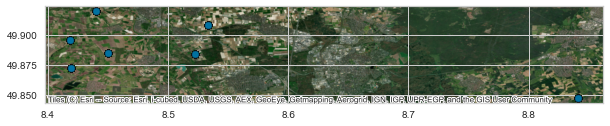

In [30]:
# Visualize Points
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', )
cx.add_basemap(ax=ax, source=cx.providers.Esri.WorldImagery, crs=gdf.crs, zoom = 'auto')
#for x, y, label in zip(longitude, latitude, [str(x) for x in point_id]):
#    ax.annotate(label, xy=(x, y))

## Add Rainfall data

    Für Morning Aquisition also 5 uhr ist 0 day der tag vor dem tag und für abend aquisition also 17 uhr ist 0 day der gleiche tag
    0 day
    1 day
    2 day
    
    ONLY FOR GERMAN !!!

In [31]:
RADOLAN = xr.open_dataset('D:/jupy_data/precipitation_1km.nc')
pp_24h, pp_48h, pp_72h = list(), list(), list()
midday = dt.time(12,0)

for index, row in gdf.iterrows():
    pp_loc = RADOLAN.sel(latitude=row.geometry.y, longitude=row.geometry.x, method='nearest').sel(time=slice(row.date.date() - pd.Timedelta('3d'), row.date.date())).precipitation_1km
    if row.date.time() > midday:
        try:
            pp_24h.append(pp_loc.isel(time=3).values)
            pp_48h.append(pp_loc.isel(time=slice(2,4)).sum().values)  
            pp_72h.append(pp_loc.isel(time=slice(1,4)).sum().values)  
        except:
            pp_24h.append(np.nan)
            pp_48h.append(np.nan)
            pp_72h.append(np.nan)
    else:
        try:
            pp_24h.append(pp_loc.isel(time=2).values)
            pp_48h.append(pp_loc.isel(time=slice(1,3)).sum().values)  
            pp_72h.append(pp_loc.isel(time=slice(0,3)).sum().values)  
        except:
            pp_24h.append(np.nan)
            pp_48h.append(np.nan)
            pp_72h.append(np.nan)
gdf['pp_24h'] = pp_24h
gdf['pp_48h'] = pp_48h
gdf['pp_72h'] = pp_72h

RADOLAN = None
pp_24h, pp_48h, pp_72h = None, None, None

In [32]:
df = gdf

## Add Soil Moisture data

In [33]:
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Load pre trained model
cnn_basic_model = load_model('C://Users/USER/Desktop/Master_Irrigation/03_GIS/cnn_models/ssm_30m')

features = ['VV', 'VH', 'angle', 'NDVI', 'platform_A', 'platform_B', 'orbit_ASCENDING',
                'orbit_DESCENDING', 'day_of_year','mean_2m_air_temperature','maximum_2m_air_temperature',
                'minimum_2m_air_temperature', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 
                'RedEdge4', 'NIR', 'WaterVapor', 'SWIR1', 'SWIR2']

# One-Hot Encoding
df_predict = pd.get_dummies(data = df, columns=['platform', 'orbit'])

#Normalization
scaler = MinMaxScaler(feature_range=(0, 1), copy = False)
df_predict[features] = scaler.fit_transform(X = df_predict[features])

# Change position in DataFrame
df_predict.insert(0, 'VV', df_predict.pop('VV'))
df_predict.insert(1, 'VH', df_predict.pop('VH'))
df_predict.insert(2, 'angle', df_predict.pop('angle'))
df_predict.insert(3, 'NDVI', df_predict.pop('NDVI'))
df_predict.insert(4, 'platform_A', df_predict.pop('platform_A'))
df_predict.insert(5, 'platform_B', df_predict.pop('platform_B'))
df_predict.insert(6, 'orbit_ASCENDING', df_predict.pop('orbit_ASCENDING'))
df_predict.insert(7, 'orbit_DESCENDING', df_predict.pop('orbit_DESCENDING'))
df_predict.insert(8, 'day_of_year', df_predict.pop('day_of_year'))
df_predict.insert(9, 'mean_2m_air_temperature', df_predict.pop('mean_2m_air_temperature'))
df_predict.insert(10, 'maximum_2m_air_temperature', df_predict.pop('maximum_2m_air_temperature'))
df_predict.insert(11, 'minimum_2m_air_temperature', df_predict.pop('minimum_2m_air_temperature'))
df_predict.insert(12, 'Blue', df_predict.pop('Blue'))
df_predict.insert(13, 'Green', df_predict.pop('Green'))
df_predict.insert(14, 'Red', df_predict.pop('Red'))
df_predict.insert(15, 'RedEdge1', df_predict.pop('RedEdge1'))
df_predict.insert(16, 'RedEdge2', df_predict.pop('RedEdge2'))
df_predict.insert(17, 'RedEdge3', df_predict.pop('RedEdge3'))
df_predict.insert(18, 'RedEdge4', df_predict.pop('RedEdge4'))
df_predict.insert(19, 'NIR', df_predict.pop('NIR'))
df_predict.insert(20, 'WaterVapor', df_predict.pop('WaterVapor'))
df_predict.insert(21, 'SWIR1', df_predict.pop('SWIR1'))
df_predict.insert(22, 'SWIR2', df_predict.pop('SWIR2'))

# Predict Surface Soil Moisture ValuesValues
predict_ssm_scale = cnn_basic_model.predict(df_predict[features])

# Add predicted smm values to initial dataframe
df['ssm'] = predict_ssm_scale

df.to_csv(r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/DataFrame_ried_samples_30m_17-19.csv', index=False)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
# LTS soil samples
gdf = pd.read_csv(r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/DataFrame_Grassland_DE.csv'
            ,).drop('Unnamed: 0', axis=1)
print(len(gdf))

207960


C:\Users\USER\Anaconda3\envs\dev1\lib\site-packages\IPython\core\interactiveshell.py:3524: DtypeWarning: Columns (48) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# ried soil samples
gdf = pd.read_csv(r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/DataFrame_ried_samples.csv'
            ,).drop('Unnamed: 0', axis=1)
print(len(gdf))

3794


In [2]:
## delete last function part because index=False while saving 
# ried soil samples 30m 17-19
gdf = pd.read_csv(r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/DataFrame_ried_samples_30m_17-19.csv'
            ,).drop('Unnamed: 0', axis=1)
print(len(gdf))

2516


In [5]:
gdf

,POINT_ID,date,platform,orbit,VV,VH,angle,img_id,Aerosols,Blue,...,INTERNATIONAL,ISSS,FAO_nr,USDA_nr,INTERNATIONAL_nr,ISSS_nr,pp_24h,pp_48h,pp_72h,ssm
0,1,2017-01-03 05:34:08,A,DESCENDING,-11.013139,-23.606548,42.091240,S1A_IW_GRDH_1SDV_20170103T053408_20170103T0534...,NaN,NaN,...,loamy sand,loamy sand,1,4,2,7,0.2,0.2,0.200000,NaN
1,1,2017-01-08 05:42:17,A,DESCENDING,-10.586973,-20.899289,33.168736,S1A_IW_GRDH_1SDV_20170108T054217_20170108T0542...,NaN,NaN,...,loamy sand,loamy sand,1,4,2,7,0.0,0.0,0.200000,NaN
2,1,2017-01-11 17:15:41,A,ASCENDING,-6.396443,-20.470305,39.153461,S1A_IW_GRDH_1SDV_20170111T171541_20170111T1716...,NaN,NaN,...,loamy sand,loamy sand,1,4,2,7,0.9,5.0,5.000000,NaN
3,1,2017-01-15 05:34:08,A,DESCENDING,-11.427189,-22.813749,42.088970,S1A_IW_GRDH_1SDV_20170115T053408_20170115T0534...,NaN,NaN,...,loamy sand,loamy sand,1,4,2,7,0.3,9.0,19.099998,NaN
4,1,2017-01-20 05:42:17,A,DESCENDING,-12.121242,-22.815012,33.173534,S1A_IW_GRDH_1SDV_20170120T054217_20170120T0542...,0.2324,0.1668,...,loamy sand,loamy sand,1,4,2,7,0.0,0.0,0.000000,0.196550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3789,7,2019-12-25 05:33:42,B,DESCENDING,-1.001384,-8.600652,40.800640,S1B_IW_GRDH_1SDV_20191225T053342_20191225T0534...,0.1805,0.1375,...,silty loam,silt loam,0,0,0,8,NaN,NaN,NaN,0.172915
3790,7,2019-12-27 17:16:12,A,ASCENDING,-7.375970,-14.996318,40.352856,S1A_IW_GRDH_1SDV_20191227T171612_20191227T1716...,0.1805,0.1375,...,silty loam,silt loam,0,0,0,8,NaN,NaN,NaN,0.151923
3791,7,2019-12-28 17:07:08,B,ASCENDING,-10.867599,-15.271474,31.116236,S1B_IW_GRDH_1SDV_20191228T170708_20191228T1707...,0.1805,0.1375,...,silty loam,silt loam,0,0,0,8,NaN,NaN,NaN,0.159802
3792,7,2019-12-30 05:41:41,B,DESCENDING,-6.065929,-11.053698,31.614723,S1B_IW_GRDH_1SDV_20191230T054141_20191230T0542...,0.1805,0.1375,...,silty loam,silt loam,0,0,0,8,NaN,NaN,NaN,0.202962


<AxesSubplot:>

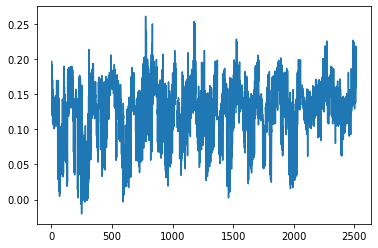

In [4]:
gdf.ssm.plot()

## Subset data

In [4]:
#gdf['FAO'] = gdf.loc[:,'FAO'].map(lambda x: if x is np.nan: pd.NA else x)
for col in ['FAO', 'FAO_nr', 'ISSS_nr', 'ISSS']:
    gdf[col].map(lambda x: pd.NA if x is np.nan else x)
#gdf['FAO_nr'] = gdf.loc[:,'FAO_nr'].map(lambda x: pd.NA if x is np.nan else x)
gdf.dropna(how='any', subset=['FAO', 'FAO_nr', 'ISSS_nr', 'ISSS'], inplace=True)

# Conversation
gdf['minimum_2m_air_temperature'] = gdf['minimum_2m_air_temperature'] -273.15
gdf['maximum_2m_air_temperature'] = gdf['maximum_2m_air_temperature'] -273.15
gdf['mean_2m_air_temperature'] = gdf['mean_2m_air_temperature'] -273.15

#Drop frozen grounds
#gdf = gdf[gdf['minimum_2m_air_temperature'] > 1]

# Dtype Transformation
gdf['date'] = gdf.loc[:,'date'].astype('datetime64[ns]')
gdf['date_y'] = gdf.loc[:,'date_y'].astype('datetime64[ns]')
gdf.loc[:,['FAO_nr']] = gdf.loc[:,['FAO_nr']].astype('int64')
gdf.loc[:,['USDA_nr']] = gdf.loc[:,['USDA_nr']].astype('int64')
gdf.loc[:,['INTERNATIONAL_nr']] = gdf.loc[:,['INTERNATIONAL_nr']].astype('int64')
gdf.loc[:,['ISSS_nr']] = gdf.loc[:,['ISSS_nr']].astype('int64')
gdf.loc[:,['pp_24h', 'pp_48h', 'pp_72h']] = gdf.loc[:,['pp_24h', 'pp_48h', 'pp_72h']].astype('float64')

#Add extra Columns
gdf['FAO'] = gdf.loc[:,['FAO_nr']]
gdf['USDA'] = gdf.loc[:,['USDA_nr']]
gdf['INTERNATIONAL'] = gdf.loc[:,['INTERNATIONAL_nr']]
gdf['ISSS'] = gdf.loc[:,['ISSS_nr']]
#gdf['longitude'] = gdf['geometry'].x
#gdf['latitude'] = gdf['geometry'].y

#One Hot Encoding
gdf = pd.DataFrame(pd.get_dummies(gdf, columns=['FAO_nr', 'USDA_nr', 'INTERNATIONAL_nr', 'ISSS_nr', 'orbit', 'platform']))
print(len(gdf))

2516


In [5]:
df_sub = gdf

<AxesSubplot:title={'center':'Bodenfeuchte'}>

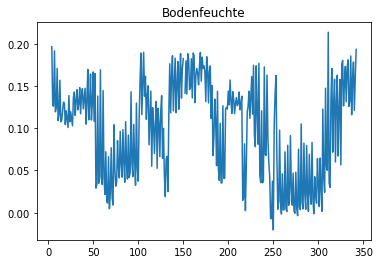

In [20]:
df_sub[df_sub.POINT_ID == 1].ssm.plot(title='Bodenfeuchte')

## Specific time series selctions

In [183]:
df_ = pd.DataFrame({'POINT_ID' : df_sub.POINT_ID, 'USDA' : df_sub.USDA})
df_.drop_duplicates(inplace=True)
df1 = pd.concat([df_,df_.iloc[-2:-1]], ignore_index=False)
df_['len_ts'] = df1.iloc[1:].index - df_.index
df_ = df_.iloc[:-1].reset_index(drop=True)
df_[['USDA', 'len_ts']].max()
df_ = df_[df_.index.isin([x[1] for x in df_.groupby('USDA')['len_ts'].nlargest(1).index])]
df_sub = df_sub[df_sub['POINT_ID'].isin(df_['POINT_ID'])]
df_sub = df_sub[df_sub['date'].dt.month.isin([4,5,6,7,8,9,10])]

In [151]:
df_sub.groupby('POINT_ID').describe()

VV                                                        \
          count       mean       std        min        25%        50%   
POINT_ID                                                                
41783392  421.0 -12.012278  2.303266 -18.129573 -13.516586 -12.275100   
42763462  422.0 -11.145862  2.229776 -17.482530 -12.697266 -11.246510   
42783474  422.0 -13.770646  2.579920 -24.449466 -15.401611 -13.756260   
43723086  421.0 -15.020651  2.029134 -20.831944 -16.223707 -15.035761   
44523310  422.0 -15.799983  2.113611 -21.486450 -17.187709 -15.740334   
45203356  422.0 -14.569066  2.217895 -21.021114 -16.074982 -14.615121   
45282904  316.0 -13.411638  2.161696 -19.362743 -14.780158 -13.319302   
45383306  423.0 -13.509875  2.306687 -21.036547 -14.958814 -13.360559   
46003390  425.0 -14.988658  2.604301 -22.696152 -16.789942 -14.952623   
46323122  424.0 -13.271268  1.979653 -19.171736 -14.582569 -13.308278   

                                  VH             ... platform_A       \
                75%       max  count       mean  ...        75%  max   
POINT_ID                                         ...                   
41783392 -10.706007 -3.614475  421.0 -18.584368  ...        1.0  1.0   
42763462  -9.775974 -3.315676  422.0 -17.789700  ...        1.0  1.0   
42783474 -12.097021 -5.964079  422.0 -19.227087  ...        1.0  1.0   
43723086 -13.783424 -8.535576  421.0 -21.538502  ...        1.0  1.0   
44523310 -14.402459 -6.901968  422.0 -22.404826  ...        1.0  1.0   
45203356 -13.084515 -7.937853  422.0 -20.525936  ...        1.0  1.0   
45282904 -11.875593 -7.419550  316.0 -19.634217  ...        1.0  1.0   
45383306 -12.000999 -5.494248  423.0 -20.377195  ...        1.0  1.0   
46003390 -13.073280 -7.237887  425.0 -21.452820  ...        1.0  1.0   
46323122 -12.009378 -7.769549  424.0 -18.732137  ...        1.0  1.0   

         platform_B                                               
              count      mean       std  min  25%  50%  75%  max  
POINT_ID                                                          
41783392      421.0  0.494062  0.500560  0.0  0.0  0.0  1.0  1.0  
42763462      422.0  0.502370  0.500588  0.0  0.0  1.0  1.0  1.0  
42783474      422.0  0.502370  0.500588  0.0  0.0  1.0  1.0  1.0  
43723086      421.0  0.501188  0.500593  0.0  0.0  1.0  1.0  1.0  
44523310      422.0  0.500000  0.500593  0.0  0.0  0.5  1.0  1.0  
45203356      422.0  0.497630  0.500588  0.0  0.0  0.0  1.0  1.0  
45282904      316.0  0.500000  0.500793  0.0  0.0  0.5  1.0  1.0  
45383306      423.0  0.498818  0.500591  0.0  0.0  0.0  1.0  1.0  
46003390      425.0  0.501176  0.500588  0.0  0.0  1.0  1.0  1.0  
46323122      424.0  0.497642  0.500585  0.0  0.0  0.0  1.0  1.0  

[10 rows x 712 columns]

## Outlizers
Maybe not necesarry with 30m mean values from s1 s2 era5?

In [ ]:
# Drop lower and upper 1% of data to eliminate outliers
for column in ['VV', 'VH', 'NDVI', 'ssm']:
    df_sub = df_sub[df_sub[column].gt(gdf[column].quantile(0.01)) & df_sub[column].lt(df_sub[column].quantile(0.99))]

In [ ]:
print(len(df_sub))

## Normalization

### for all values together

In [37]:
scaler = MinMaxScaler() 
df_sub.loc[:,['VV', 'VH', 'NDVI','angle', 'day_of_year',
             'pp_24h', 'pp_48h', 'pp_72h','mean_2m_air_temperature','maximum_2m_air_temperature',
                'minimum_2m_air_temperature', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 
                'RedEdge4', 'NIR', 'WaterVapor', 'SWIR1', 'SWIR2', 'ssm']
          ] = scaler.fit_transform(df_sub.loc[:,['VV', 'VH', 'NDVI','angle', 'day_of_year', 
             'pp_24h', 'pp_48h', 'pp_72h','mean_2m_air_temperature','maximum_2m_air_temperature',
                'minimum_2m_air_temperature', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 
                'RedEdge4', 'NIR', 'WaterVapor', 'SWIR1', 'SWIR2', 'ssm']]) 

df_sub.dropna(how='any', subset=['VV', 'VH', 'NDVI','angle', 'day_of_year','minimum_2m_air_temperature',
             'pp_24h', 'pp_48h', 'pp_72h','mean_2m_air_temperature','maximum_2m_air_temperature',
                'minimum_2m_air_temperature', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 
                'RedEdge4', 'NIR', 'WaterVapor', 'SWIR1', 'SWIR2', 'ssm'],inplace=True)
df_sub.reset_index(drop=True, inplace=True)

In [ ]:
list(df_sub.columns)
df_sub.coarse.max()

### for percentage values

In [ ]:
df_sub.loc[:,['sand', 'silt', 'clay', 'coarse']] = df_sub.loc[:,['sand', 'silt', 'clay', 'coarse']] / 100

### for every location indepentently

In [ ]:
scaler = MinMaxScaler() 
df_sub.loc[:,['VV', 'VH', 'angle', 'NDVI', 'day_of_year', 'minimum_2m_air_temperature','pp_24h', 'pp_48h', 'pp_72h']] = df_sub.groupby('POINT_ID')[['VV', 'VH', 'angle', 'NDVI', 'day_of_year', 'minimum_2m_air_temperature','pp_24h', 'pp_48h', 'pp_72h']].agg(scaler.fit_transform()) 

https://www.tensorflow.org/tutorials/structured_data/time_series normalize only with training data

In [ ]:
# Normalize Data
df_sub['VV'] = df_sub.groupby('POINT_ID')['VV'].transform(lambda x: (x - x.mean()) / x.std())
df_sub['VH'] = df_sub.groupby('POINT_ID')['VH'].transform(lambda x: (x - x.mean()) / x.std())
df_sub['angle'] = df_sub.groupby('POINT_ID')['angle'].transform(lambda x: (x - x.mean()) / x.std())
df_sub['NDVI'] = df_sub.groupby('POINT_ID')['NDVI'].transform(lambda x: (x - x.mean()) / x.std())
df_sub['day_of_year'] = df_sub.groupby('POINT_ID')['day_of_year'].transform(lambda x: (x - x.mean()) / x.std())
df_sub['dewpoint_2m_temperature'] = df_sub.groupby('POINT_ID')['dewpoint_2m_temperature'].transform(lambda x: (x - x.mean()) / x.std())
df_sub['maximum_2m_air_temperature'] = df_sub.groupby('POINT_ID')['maximum_2m_air_temperature'].transform(lambda x: (x - x.mean()) / x.std())
df_sub['mean_2m_air_temperature'] = df_sub.groupby('POINT_ID')['mean_2m_air_temperature'].transform(lambda x: (x - x.mean()) / x.std())
df_sub['minimum_2m_air_temperature'] = df_sub.groupby('POINT_ID')['minimum_2m_air_temperature'].transform(lambda x: (x - x.mean()) / x.std())
df_sub['surface_pressure'] = df_sub.groupby('POINT_ID')['surface_pressure'].transform(lambda x: (x - x.mean()) / x.std())
df_sub['total_precipitation'] = df_sub['total_precipitation'].apply(lambda x: (x - df_sub['total_precipitation'].mean()) / df_sub['total_precipitation'].std())
df_sub['u_component_of_wind_10m'] = df_sub.groupby('POINT_ID')['u_component_of_wind_10m'].transform(lambda x: (x - x.mean()) / x.std())
df_sub['v_component_of_wind_10m'] = df_sub.groupby('POINT_ID')['v_component_of_wind_10m'].transform(lambda x: (x - x.mean()) / x.std())

df_sub.reset_index(drop=True, inplace=True)

## Plot normalized Distribution 

In [ ]:
df_std = (df_sub.iloc[:,2:11] - df_sub.iloc[:,2:11].mean()) / df_sub.iloc[:,2:11].std()
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df_sub.iloc[:,2:11].keys(), rotation=90)

In [ ]:
df_sub.columns

# Import point without any information of soil

In [8]:
gdf = add_radolan_sf(r'C:\Users\USER\Desktop\Master_Irrigation\03_GIS\soil_classification\download_ts\ried_soil_samples_30m_17-19\POINT_ID_1_8.5332_49.9083.geojson')
gdf = prepare_data(gdf)

FileNotFoundError: [Errno 2] No such file or directory: b'C:\\opt\\bitnami\\projects\\data\\AI_models\\precipitation_1km.nc'

In [6]:
import geopandas as gpd
import pandas as pd
import datetime as dt
import xarray as xr
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import joblib

def add_radolan_sf(filepath):
    
    gdf = gpd.read_file(filepath, ignore_index=True)
    gdf = gdf.dropna(how='any')
    gdf['date'] = gdf['date'].astype('datetime64[ns]')
    gdf['day_of_year'] = gdf['date'].dt.day_of_year
    
    RADOLAN = xr.open_dataset('/opt/bitnami/projects/data/AI_models/precipitation_1km.nc')
    pp_24h, pp_48h, pp_72h = list(), list(), list()
    midday = dt.time(12,0)

    for index, row in gdf.iterrows():
        pp_loc = RADOLAN.sel(latitude=row.geometry.y, longitude=row.geometry.x, method='nearest').sel(time=slice(row.date.date() - pd.Timedelta('3d'), row.date.date())).precipitation_1km
        if row.date.time() > midday:
            try:
                pp_24h.append(pp_loc.isel(time=3).values)
                pp_48h.append(pp_loc.isel(time=slice(2,4)).sum().values)  
                pp_72h.append(pp_loc.isel(time=slice(1,4)).sum().values)  
            except:
                pp_24h.append(np.nan)
                pp_48h.append(np.nan)
                pp_72h.append(np.nan)
        else:
            try:
                pp_24h.append(pp_loc.isel(time=2).values)
                pp_48h.append(pp_loc.isel(time=slice(1,3)).sum().values)  
                pp_72h.append(pp_loc.isel(time=slice(0,3)).sum().values)  
            except:
                pp_24h.append(np.nan)
                pp_48h.append(np.nan)
                pp_72h.append(np.nan)
    gdf['pp_24h'] = pp_24h
    gdf['pp_48h'] = pp_48h
    gdf['pp_72h'] = pp_72h

    RADOLAN = None
    pp_24h, pp_48h, pp_72h = None, None, None
    
    return gdf

def prepare_data(gdf):
    
    # Conversation
    gdf['minimum_2m_air_temperature'] = gdf['minimum_2m_air_temperature'] -273.15
    gdf['maximum_2m_air_temperature'] = gdf['maximum_2m_air_temperature'] -273.15
    gdf['mean_2m_air_temperature'] = gdf['mean_2m_air_temperature'] -273.15
    
    # Dtype Transformation
    gdf['date'] = gdf.loc[:,'date'].astype('datetime64[ns]')
    gdf.loc[:,['pp_24h', 'pp_48h', 'pp_72h']] = gdf.loc[:,['pp_24h', 'pp_48h', 'pp_72h']].astype('float64')

    #One Hot Encoding
    gdf = pd.DataFrame(pd.get_dummies(gdf, columns=['orbit', 'platform']))
    
    # Normaliztion
    scaler = MinMaxScaler() 
    gdf.loc[:,['VV', 'VH', 'NDVI','angle', 'day_of_year',
             'pp_24h', 'pp_48h', 'pp_72h','mean_2m_air_temperature','maximum_2m_air_temperature',
                'minimum_2m_air_temperature', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 
                'RedEdge4', 'NIR', 'WaterVapor', 'SWIR1', 'SWIR2', 'ssm']
          ] = scaler.fit_transform(gdf.loc[:,['VV', 'VH', 'NDVI','angle', 'day_of_year', 
             'pp_24h', 'pp_48h', 'pp_72h','mean_2m_air_temperature','maximum_2m_air_temperature',
                'minimum_2m_air_temperature', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 
                'RedEdge4', 'NIR', 'WaterVapor', 'SWIR1', 'SWIR2', 'ssm']]) 

    gdf.reset_index(drop=True, inplace=True)
    return gdf

C:\Users\USER\Anaconda3\envs\dev1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\USER\Anaconda3\envs\dev1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\USER\Anaconda3\envs\dev1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\USER\Anaconda3\envs\dev1\lib\site-packages\tensorflow\python\framework

# Machine Learning

In [3]:
#Utilities
from tsfresh import extract_relevant_features

from imblearn.over_sampling import SMOTE

from yellowbrick.classifier import ClassificationReport
from yellowbrick.model_selection import CVScores
from yellowbrick.regressor import prediction_error
from yellowbrick.classifier import confusion_matrix as yellow_confusion_matrix

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

#Classifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

from keras.wrappers.scikit_learn import KerasClassifier

In [16]:
model = joblib.load(r'C://Users/USER/Desktop/Master_Irrigation/05_Results/classification/models/random_forest/1_rf_fullrows_nopara_usda.sav')

In [15]:
def save_confusion_matrix(X_test, y_test, model, labels, display_labels, fname, title_cm):
    cm = ConfusionMatrixDisplay.from_predictions(y_test, model.predict(X_test), labels = labels, display_labels = display_labels)
    cm.ax_.axis('auto') 
    cm.ax_.set_xticklabels(cm.ax_.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'Confusion Matrix {title_cm}')
    plt.grid(False)
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    return plt.show()  

def score_model(X_train, X_test, y_train, y_test, model, labels, target_names, fname, train):
    """
    Test various estimators.
    """
        
    # Instantiate the classification model and visualizer
    if train == 'yes':
        model.fit(X_train, y_train)
    # Compute and return F1 (harmonic mean of precision and recall)
    report_dict = classification_report(y_test, model.predict(X_test), 
                                labels = labels, 
                                target_names = target_names,
                                zero_division = 1,
                                output_dict=True)

    repdf = pd.DataFrame(report_dict).round(2).transpose()
    repdf.insert(loc=0, column='class', value=target_names + ["accuracy", "macro avg", "weighted avg"])
    repdf.to_csv(fname + '.csv', index=False)
    title_cm = ''
    save_confusion_matrix(X_test, y_test, model, labels, 
                          target_names, 
                          fname + '.png', 
                          title_cm
                         )

    return model

## Model Selection

### Imbalanced without outlierz and minmax scaler for all variables

#### classification

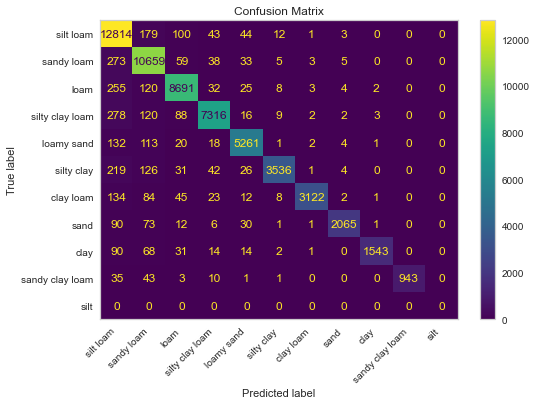

                 precision    recall  f1-score   support

      silt loam       0.89      0.97      0.93     13196
     sandy loam       0.92      0.96      0.94     11075
           loam       0.96      0.95      0.95      9140
silty clay loam       0.97      0.93      0.95      7834
     loamy sand       0.96      0.95      0.96      5552
     silty clay       0.99      0.89      0.93      3985
      clay loam       1.00      0.91      0.95      3431
           sand       0.99      0.91      0.95      2279
           clay       0.99      0.88      0.93      1763
sandy clay loam       1.00      0.91      0.95      1036
           silt       1.00      1.00      1.00         0

      micro avg       0.94      0.94      0.94     59291
      macro avg       0.97      0.93      0.95     59291
   weighted avg       0.95      0.94      0.94     59291



In [23]:
X = df_sub[['VV', 'VH', 'NDVI','angle', 'day_of_year', 'platform_A', 'platform_B', 
            'orbit_ASCENDING', 'orbit_DESCENDING','minimum_2m_air_temperature',
             'pp_24h', 'pp_48h', 'pp_72h','mean_2m_air_temperature','maximum_2m_air_temperature',
                'minimum_2m_air_temperature', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 
                'RedEdge4', 'NIR', 'WaterVapor', 'SWIR1', 'SWIR2', 'ssm']].values

y = df_sub['USDA'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,random_state=100)
labels = list(USDA_to_numerical['USDA'].values())
target_names = list(USDA_to_numerical['USDA'].keys())

model = RandomForestClassifier()
model = score_model(X_train, X_test, y_train, y_test, model, labels, target_names,
                    'C://Users/USER/Desktop/Master_Irrigation/05_Results/classification/ried_soil_samples/USDA_rf_trained_model_allrows_noparas_IB_',
                   train='yes')
print(classification_report(y_test, model.predict(X_test), labels = labels, target_names = target_names, zero_division=1))

with open('C://Users/USER/Desktop/Master_Irrigation/05_Results/classification/models/random_forest/rf_fullrows_nopara_usda.sav', 'wb') as f:
    joblib.dump(model, f)

In [38]:
df_sub.groupby(['POINT_ID', 'USDA'])['USDA'].describe()[['count']]

,,count
POINT_ID,USDA,
1,4,338.0
2,4,338.0
3,0,333.0
4,0,334.0
5,0,331.0
6,0,334.0
7,0,444.0


In [39]:
X_list = [(x[0], x[1][['VV', 'VH', 'NDVI','angle', 'day_of_year', 'platform_A', 'platform_B',  #[df_sub['POINT_ID'] == 3]
            'orbit_ASCENDING', 'orbit_DESCENDING','minimum_2m_air_temperature',
             'pp_24h', 'pp_48h', 'pp_72h','mean_2m_air_temperature','maximum_2m_air_temperature',
                'minimum_2m_air_temperature', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 
                'RedEdge4', 'NIR', 'WaterVapor', 'SWIR1', 'SWIR2','ssm']].values) for x in df_sub.groupby('POINT_ID')]

y_list = [(x[0], x[1]['USDA'].values) for x in df_sub.groupby('POINT_ID')] #[df_sub['POINT_ID'] == 3]

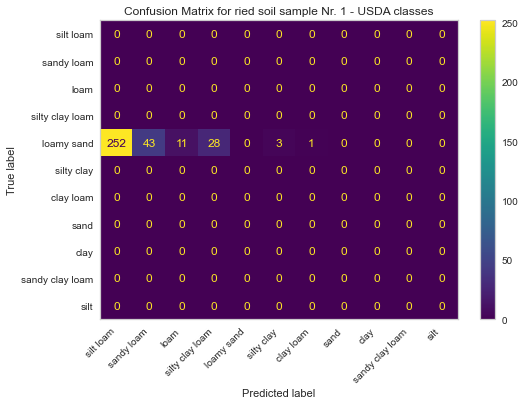

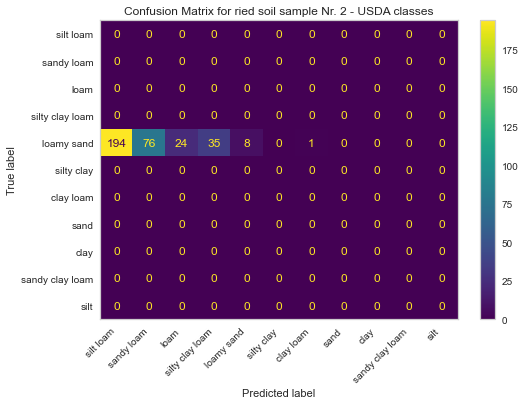

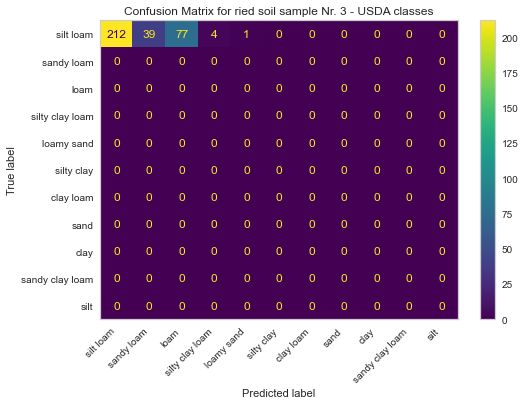

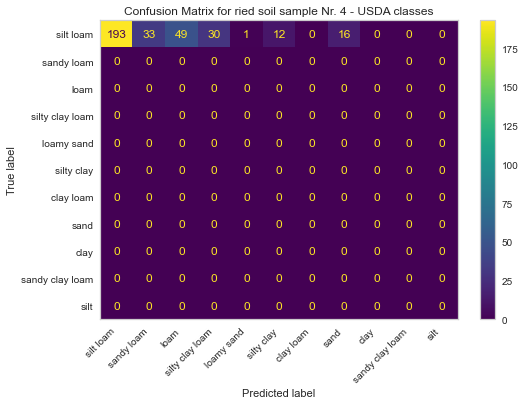

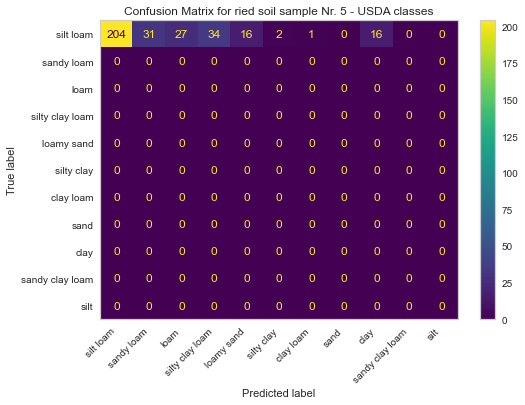

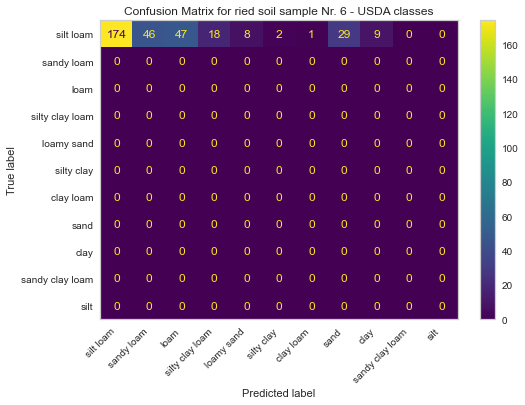

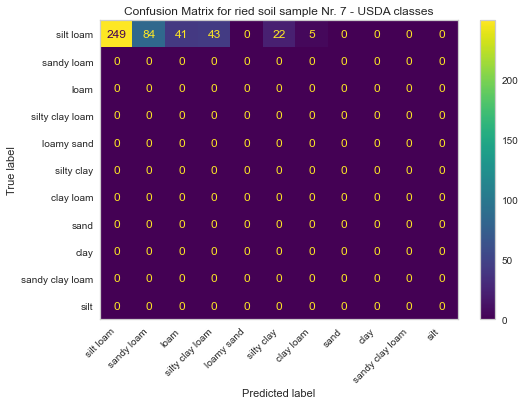

In [40]:
labels = list(USDA_to_numerical['USDA'].values())
target_names = list(USDA_to_numerical['USDA'].keys())
for X,y in zip(X_list,y_list):
    save_confusion_matrix(X[1], y[1], model, labels, target_names,
                          f'C://Users/USER/Desktop/Master_Irrigation/05_Results/classification/ried_soil_samples/30m_17-19/ried_soil_samples_{str(X[0])}_usda_rf1_cm_',
                         f'for ried soil sample Nr. {X[0]} - USDA classes')

In [252]:
X = df_sub[['VV', 'VH', 'NDVI','angle', 'day_of_year', 'platform_A', 'platform_B', 
            'orbit_ASCENDING', 'orbit_DESCENDING','minimum_2m_air_temperature',
             'pp_24h', 'pp_48h', 'pp_72h','mean_2m_air_temperature','maximum_2m_air_temperature',
                'minimum_2m_air_temperature', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 
                'RedEdge4', 'NIR', 'WaterVapor', 'SWIR1', 'SWIR2','ssm']].values

y = df_sub['USDA'].values
labels = list(USDA_to_numerical['USDA'].values())
target_names = list(USDA_to_numerical['USDA'].keys())
print(classification_report(y, model.predict(X), labels = labels, target_names = target_names))

              precision    recall  f1-score   support

   silt loam       0.69      0.57      0.63      2667
  loamy sand       0.28      0.12      0.17      1005

   micro avg       0.62      0.45      0.52      3672
   macro avg       0.48      0.35      0.40      3672
weighted avg       0.58      0.45      0.50      3672



In [253]:
df_sub['usda_prediction'] = model.predict(X)

In [259]:
df_sub.groupby(['POINT_ID', 'usda_prediction'])['usda_prediction'].describe()[['count']]

count
POINT_ID usda_prediction       
1        0                371.0
         1                 50.0
         2                 34.0
         3                 28.0
         4                  3.0
         5                  5.0
         6                  8.0
2        0                324.0
         1                 75.0
         2                 41.0
         3                 43.0
         4                  7.0
         5                  5.0
         6                  6.0
         7                  5.0
3        0                294.0
         1                 78.0
         2                 69.0
         3                 45.0
         4                  4.0
         6                  6.0
         7                  5.0
4        0                285.0
         1                 56.0
         2                 78.0
         3                 45.0
         4                  6.0
         5                 18.0
         6                  7.0
         7                  6.0
         8                  1.0
5        0                297.0
         1                 37.0
         2                 75.0
         3                 29.0
         4                 32.0
         5                  4.0
         6                  6.0
         7                  1.0
         8                 11.0
6        0                219.0
         1                 57.0
         2                 93.0
         3                 60.0
         4                 27.0
         5                  1.0
         6                  2.0
         7                 43.0
7        0                434.0
         1                 94.0
         2                 75.0
         3                 31.0
         5                 18.0
         6                 11.0
         8                  7.0

In [ ]:
models = [
    ExtraTreesClassifier(), RandomForestClassifier(), #n_estimators=300, n_estimators=300
    SGDClassifier(), KNeighborsClassifier(), #max_iter=100, tol=1e-3
    LogisticRegression(), LogisticRegressionCV(), # solver='lbfgs' cv=3
    BaggingClassifier(), #SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC()
]

X = df_sub[['VV', 'VH', 'NDVI','angle', 'day_of_year', 'platform_A', 'platform_B', 
            'orbit_ASCENDING', 'orbit_DESCENDING','minimum_2m_air_temperature',
             'pp_24h', 'pp_48h', 'pp_72h','mean_2m_air_temperature','maximum_2m_air_temperature',
                'minimum_2m_air_temperature', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 
                'RedEdge4', 'NIR', 'WaterVapor', 'SWIR1', 'SWIR2','ssm']].values

def save_confusion_matrix(X_test, y_test, model, labels, display_labels, fname):
    cm = ConfusionMatrixDisplay.from_predictions(y_test, model.predict(X_test), labels = labels, display_labels = display_labels)
    cm.ax_.axis('auto') 
    cm.ax_.set_xticklabels(cm.ax_.get_xticklabels(), rotation=45, ha='right')
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    return plt.show()  

def score_model(X, model, soil_class):
    """
    Test various estimators.
    """
    if soil_class == 'INTERNATIONAL':
        labels = list(INTERNATIONAL_to_numerical['INTERNATIONAL'].values())
        target_names = list(INTERNATIONAL_to_numerical['INTERNATIONAL'].keys())
        y = df_sub['INTERNATIONAL'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,random_state=100)
    elif soil_class == 'ISSS':
        labels = list(ISSS_to_numerical['ISSS'].values())
        target_names = list(ISSS_to_numerical['ISSS'].keys())
        y = df_sub['ISSS'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,random_state=100)
    elif soil_class == 'USDA':
        labels = list(USDA_to_numerical['USDA'].values())
        target_names = list(USDA_to_numerical['USDA'].keys())
        y = df_sub['USDA'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,random_state=100)
    elif soil_class == 'FAO':
        labels = list(FAO_to_numerical['FAO'].values())
        target_names = list(FAO_to_numerical['FAO'].keys())
        y = df_sub['FAO'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,random_state=100)
        
    # Instantiate the classification model and visualizer
    model.fit(X_train, y_train)
    # Compute and return F1 (harmonic mean of precision and recall)
    report_dict = classification_report(y_test, model.predict(X_test), 
                                labels = labels, 
                                target_names = target_names,
                                output_dict=True)

    repdf = pd.DataFrame(report_dict).round(2).transpose()
    repdf.insert(loc=0, column='class', value=target_names + ["accuracy", "macro avg", "weighted avg"])
    repdf.to_csv('C://Users/USER/Desktop/Master_Irrigation/05_Results/classification/out1/' + soil_class + '_' + 'cp_rows_IB_nopara_out1_' + str(model) + '.csv', index=False)
    print('Write: ' + 'C://Users/USER/Desktop/Master_Irrigation/05_Results/classification/out1/' + soil_class + '_' + 'cp_rows_IB_nopara_out1_' + str(model) + '.csv')
    
    save_confusion_matrix(X_test, y_test, model, labels, 
                          target_names, 
                          'C://Users/USER/Desktop/Master_Irrigation/05_Results/classification/out1/' + soil_class + '_' + 'cm_rows_IB_nopara_out1_' + str(model) + '.png'
                         )

    return report_dict

for model in models:
    for soil_class in ['FAO', 'USDA', 'ISSS', 'INTERNATIONAL']:  
        print(model, soil_class)
        score_model(X, model, soil_class)

#### regression

In [ ]:
# Load the regression dataset
X = df_sub[['VV', 'VH', 'NDVI','angle', 'day_of_year', 'platform_A', 'platform_B', 
            'orbit_ASCENDING', 'orbit_DESCENDING','minimum_2m_air_temperature',
             'pp_24h', 'pp_48h', 'pp_72h','mean_2m_air_temperature','maximum_2m_air_temperature',
                'minimum_2m_air_temperature', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 
                'RedEdge4', 'NIR', 'WaterVapor', 'SWIR1', 'SWIR2', 'ssm']].values

y = df_sub['sand'].values

# Instantiate the regression model and visualizer
cv = KFold(n_splits=12, random_state=42, shuffle=True)

model = Lasso()
visualizer = CVScores(model, cv=cv, scoring='r2')

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [ ]:
# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Instantiate the linear model and visualizer
model = Lasso()
visualizer = prediction_error(model, X_train, y_train, X_test, y_test)

In [ ]:
models = [ #max_iter=100, tol=1e-3
    LogisticRegression(), LogisticRegressionCV(), # solver='lbfgs' cv=3
     #SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC()
]

X = df_sub[['VV', 'VH', 'NDVI','angle', 'day_of_year', 'platform_A', 'platform_B', 
            'orbit_ASCENDING', 'orbit_DESCENDING','minimum_2m_air_temperature',
             'pp_24h', 'pp_48h', 'pp_72h','mean_2m_air_temperature','maximum_2m_air_temperature',
                'minimum_2m_air_temperature', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 
                'RedEdge4', 'NIR', 'WaterVapor', 'SWIR1', 'SWIR2', 'ssm']].values

y = df_sub['coarse'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,random_state=100)

def save_confusion_matrix(X_test, y_test, model, labels, display_labels, fname):
    cm = ConfusionMatrixDisplay.from_predictions(y_test, model.predict(X_test), labels = labels, display_labels = display_labels)
    cm.ax_.axis('auto') 
    cm.ax_.set_xticklabels(cm.ax_.get_xticklabels(), rotation=45, ha='right')
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    return plt.show()  

def score_model(X_train, X_test, y_train, y_test, model):
    """
    Test various estimators.
    """
        
    # Instantiate the classification model and visualizer
    model.fit(X_train, y_train)
    # Compute and return F1 (harmonic mean of precision and recall)
    report_dict = classification_report(y_test, model.predict(X_test), 
                                #labels = labels, 
                                #target_names = target_names,
                                output_dict=True)

    repdf = pd.DataFrame(report_dict).round(2).transpose()
    repdf.insert(loc=0, column='class', value=target_names + ["accuracy", "macro avg", "weighted avg"])
    repdf.to_csv('C://Users/USER/Desktop/Master_Irrigation/05_Results/classification/noparam_regression/' + soil_class + '_' + 'cp_rows_IB_nopara_' + str(model) + '.csv', index=False)
    print('Write: ' + 'C://Users/USER/Desktop/Master_Irrigation/05_Results/classification/noparam_regression/' + soil_class + '_' + 'cp_rows_IB_nopara_' + str(model) + '.csv')
    
    save_confusion_matrix(X_test, y_test, model, labels, 
                          target_names, 
                          'C://Users/USER/Desktop/Master_Irrigation/05_Results/classification/noparam_regression/' + soil_class + '_' + 'cm_rows_IB_nopara_' + str(model) + '.png'
                         )

    return report_dict

for model in models:
    score_model(X_train, X_test, y_train, y_test, model)

### Balanced without outlierz and minmax scaler for all variables

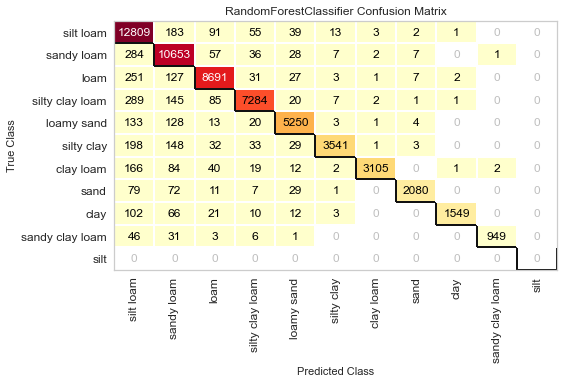

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

<Figure size 576x396 with 0 Axes>

In [206]:
X = df_sub[['VV', 'VH', 'NDVI','angle', 'day_of_year', 'platform_A', 'platform_B', 
            'orbit_ASCENDING', 'orbit_DESCENDING','minimum_2m_air_temperature',
             'pp_24h', 'pp_48h', 'pp_72h','mean_2m_air_temperature','maximum_2m_air_temperature',
                'minimum_2m_air_temperature', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 
                'RedEdge4', 'NIR', 'WaterVapor', 'SWIR1', 'SWIR2','ssm']].values
y = df_sub['USDA'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,random_state=100)


labels = list(USDA_to_numerical['USDA'].values())
target_names = list(USDA_to_numerical['USDA'].keys())
# Instantiate the visualizer with the classification model
cm = yellow_confusion_matrix(
    RandomForestClassifier(),
    X_train, y_train, X_test, y_test,
    classes=target_names
)
#plt.tight_layout()
cm.show(outpath='C://Users/USER/Desktop/Master_Irrigation/05_Results/classification/USDA_cm_RandomForest_IB_all_rows.png', dpi=150)

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

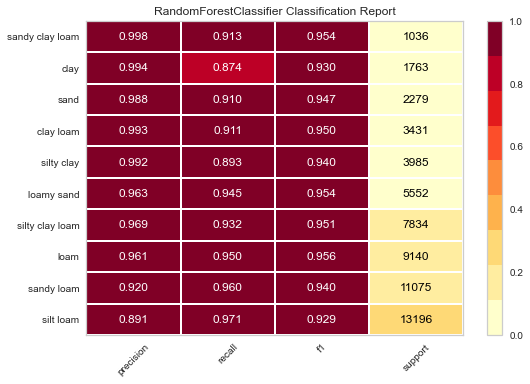

In [207]:
model = RandomForestClassifier()
visualizer = ClassificationReport(model, classes=target_names, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data

visualizer.show(outpath='C://Users/USER/Desktop/Master_Irrigation/05_Results/classification/USDA_cp_RandomForest_IB_all_rows.png', dpi=150)                       # Finalize and show the figure

## Feature Extracting

In [ ]:
# create new classes for sand
df_sub['sand_class'] = df_sub['sand']
df_sub.loc[df_sub['sand'].between(0,.15), 'sand_class'] = 0
df_sub.loc[df_sub['sand'].between(.15,.3), 'sand_class'] = 1
df_sub.loc[df_sub['sand'].between(.3,.45), 'sand_class'] = 2
df_sub.loc[df_sub['sand'].between(.6,.75), 'sand_class'] = 4
df_sub.loc[df_sub['sand'].between(.75,.9), 'sand_class'] = 5
df_sub.loc[df_sub['sand'].between(.9,1), 'sand_class'] = 6

### for all features

In [ ]:
df_features = df_sub[['POINT_ID', 'date', 'VV', 'VH', 'angle', 'NDVI', 'day_of_year',
       'minimum_2m_air_temperature', 'pp_24h', 'pp_48h', 'pp_72h',
       'platform_A', 'platform_B', 'orbit_ASCENDING', 'orbit_DESCENDING']]

y_features = df_sub[['POINT_ID','USDA']].drop_duplicates()
y_features = y_features.set_index('POINT_ID')['USDA']

relevant_features = extract_relevant_features(df_features, y_features, column_id='POINT_ID', column_sort='date')

In [ ]:
oversample = SMOTE()
X, y = oversample.fit_resample(relevant_features, y_features)

### Desicion tree full features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [ ]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
print(classification_report(y_test, decision_tree.predict(X_test),labels = list(USDA_to_numerical['USDA'].values()), target_names = list(USDA_to_numerical['USDA'].keys()) ))

In [ ]:
# Desicion Tree Hyperparameter Tuning
param_dict = {
    'max_depth' : range(1,20,3),
    'min_samples_split' : range(1,20,3),
    'min_samples_leaf' : range(1,20,3)
}

grid = GridSearchCV(decision_tree,
                   param_grid = param_dict,
                   cv=10,
                   verbose=1,
                   n_jobs=-1)
grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

In [ ]:
# RandomForest Classifier
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
print(classification_report(y_test, random_forest.predict(X_test), labels = list(USDA_to_numerical['USDA'].values()), target_names = list(USDA_to_numerical['USDA'].keys())))

In [ ]:
# Random Forest Hyperparameter Tuning
param_dict = {
    'n_estimators' : [50,100,300,1000],
    'max_depth' : range(1,100,15),
    'min_samples_split' : range(1,100,15)
}

grid = GridSearchCV(random_forest,
                   param_grid = param_dict,
                   cv=10,
                   verbose=1,
                   n_jobs=-1)
grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

In [ ]:
# GradientBoosting XGBoost Classifier
classifier = GradientBoostingClassifier()
classifier.fit(X_train, y_train)
print(classification_report(y_test, classifier.predict(X_test), labels = list(USDA_to_numerical['USDA'].values()), target_names = list(USDA_to_numerical['USDA'].keys())))

In [ ]:
# Naive Bayes Classifier
classifier = GaussianNB()
classifier.fit(X_train, y_train)
print(classification_report(y_test, classifier.predict(X_test), labels = list(USDA_to_numerical['USDA'].values()), target_names = list(USDA_to_numerical['USDA'].keys())))

In [ ]:
# SVM Support Vector Machines
classifier = SVC()
classifier.fit(X_train, y_train)
print(classification_report(y_test, classifier.predict(X_test), labels = list(USDA_to_numerical['USDA'].values()), target_names = list(USDA_to_numerical['USDA'].keys())))

In [ ]:
# AdaBoost classifier
classifier = AdaBoostClassifier()
classifier.fit(X_train, y_train)
print(classification_report(y_test, classifier.predict(X_test), labels = list(USDA_to_numerical['USDA'].values()), target_names = list(USDA_to_numerical['USDA'].keys())))

In [ ]:
# Logisitc Regression
model = LogisticRegression(solver='saga', max_iter=10000)
model.fit(X_train, y_train)
model.score(X_test, y_test)

## Descion Tree USDA full rows
https://keras.io/examples/structured_data/deep_neural_decision_forests/

# Classification
## Multi Time Series with irregular time intervals

## SKLearn multiple classifiers comparison

In [ ]:
#dataset = df_sub[df_sub['date'].dt.year.isin([2018])].values
X = df_sub[['VV', 'VH', 'NDVI','angle', 'day_of_year', 'platform_A', 'platform_B', 
            'orbit_ASCENDING', 'orbit_DESCENDING','minimum_2m_air_temperature',
             'pp_24h', 'pp_48h', 'pp_72h','mean_2m_air_temperature','maximum_2m_air_temperature',
                'minimum_2m_air_temperature', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 
                'RedEdge4', 'NIR', 'WaterVapor', 'SWIR1', 'SWIR2','ssm']].values

#X = test[['VV', 'VH', 'NDVI','angle', 'day_of_year', 'platform_A', 'platform_B', 
#            'orbit_ASCENDING', 'orbit_DESCENDING','minimum_2m_air_temperature',
#             'pp_24h', 'pp_48h', 'pp_72h','mean_2m_air_temperature','maximum_2m_air_temperature',
#                'minimum_2m_air_temperature', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 
#                'RedEdge4', 'NIR', 'WaterVapor', 'SWIR1', 'SWIR2','ssm']].values

#y = df_sub['USDA'].values
#y = df_sub['ISSS'].values
y = df_sub['INTERNATIONAL'].values
#y = df_sub['FAO'].values

#y = test['INTERNATIONAL'].values
## Split Training Test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,random_state=100)

In [ ]:
# Decision tree Classifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
#print(classification_report(y_test, decision_tree.predict(X_test), labels = list(USDA_to_numerical['USDA'].values()), target_names = list(USDA_to_numerical['USDA'].keys())))
#print(classification_report(y_test, decision_tree.predict(X_test), labels = list(FAO_to_numerical['FAO'].values()), target_names = list(FAO_to_numerical['FAO'].keys())))
#print(classification_report(y_test, decision_tree.predict(X_test), labels = list(ISSS_to_numerical['ISSS'].values()), target_names = list(ISSS_to_numerical['ISSS'].keys())))
print(classification_report(y_test, decision_tree.predict(X_test), labels = list(INTERNATIONAL_to_numerical['INTERNATIONAL'].values()), target_names = list(INTERNATIONAL_to_numerical['INTERNATIONAL'].keys())))

In [ ]:
def save_confusion_matrix(y_true,y_predict, labels, display_labels, fname):
    cm = ConfusionMatrixDisplay.from_predictions(y_test, decision_tree.predict(X_test), labels = list(INTERNATIONAL_to_numerical['INTERNATIONAL'].values()), display_labels = list(INTERNATIONAL_to_numerical['INTERNATIONAL'].keys()))
    cm.ax_.axis('auto') 
    cm.ax_.set_xticklabels(cm.ax_.get_xticklabels(), rotation=45, ha='right')
    plt.title('Confusion Matrix')
    plt.gcf().set_dpi(150)
    fig.savefig(fname, dpi=fig.dpi)
    return plt.show()

In [ ]:
save_confusion_matrix(y_true = y_test,
                      y_predict = decision_tree.predict(X_test),
                      labels = list(INTERNATIONAL_to_numerical['INTERNATIONAL'].values()), 
                      display_labels = list(INTERNATIONAL_to_numerical['INTERNATIONAL'].keys()), 
                      fnmae = 'C://USERS/USER/Desktop/Master_Irrigation/04_img/results/cm/cm_INTERNATIONAL_rows_IB_')

In [ ]:
a = precision_recall_fscore_support(y_test, decision_tree.predict(X_test), 
                                    labels = list(INTERNATIONAL_to_numerical['INTERNATIONAL'].values()),
                                   average=None)
a

In [ ]:
fig,ax = plt.subplots()
cm.text_


In [ ]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,random_state=100)

In [ ]:
# RandomForest Classifier
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
print(classification_report(y_test, random_forest.predict(X_test), labels = list(INTERNATIONAL_to_numerical['INTERNATIONAL'].values()), target_names = list(INTERNATIONAL_to_numerical['INTERNATIONAL'].keys())))
#print(classification_report(y_test, decision_tree.predict(X_test), labels = list(USDA_to_numerical['USDA'].values()), target_names = list(USDA_to_numerical['USDA'].keys())))


In [ ]:
df_sub.INT.unique()

In [ ]:
#Undersample
groups = list()
n0, n1, n2, n3, n4, n5, n6, n7, n8 = list(), list(), list(), list(), list(), list(), list(), list(), list()
n = np.empty((9,30))
for index, group in df_sub.groupby('POINT_ID'):
    group.reset_index(inplace=True, drop=True)
    g = group.loc[0,'INTERNATIONAL']
    
    if g == 0 and len(n0) < 20:
        n0.append(g)
        groups.append(group)
        
    elif g == 1 and len(n1) < 20:
        n1.append(g)
        groups.append(group)
    
    elif g == 2 and len(n2) < 20:
        n2.append(g)
        groups.append(group)
        
    elif g == 3 and len(n3) < 20:
        n3.append(g)
        groups.append(group)
        
    elif g == 4 and len(n4) < 20:
        n4.append(g)
        groups.append(group)
    
    elif g == 5 and len(n5) < 20:
        n5.append(g)
        groups.append(group)
    elif g == 6 and len(n6) < 20:
        n6.append(g)
        groups.append(group)
        
    elif g == 7 and len(n7) < 20:
        n7.append(g)
        groups.append(group)
    
    elif g == 8 and len(n8) < 20:
        n8.append(g)
        groups.append(group)        
        
test = pd.concat(groups)

In [ ]:
# Desicion Tree Hyperparameter Tuning
param_dict = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(1,15,3),
    'min_samples_split' : range(1,15,3),
    'min_samples_leaf' : range(1,15,3)
}

grid = GridSearchCV(decision_tree,
                   param_grid = param_dict,
                   cv=10,
                   verbose=1,
                   n_jobs=-1)
grid.fit(X,y)
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

In [ ]:
# Random Forest Hyperparameter Tuning
param_dict = {
    'n_estimators' : [50,100,300],
    'max_depth' : range(1,15,3),
    'min_features' : range(1,X_train.shape[1]),
    'min_samples_split' : range(1,15,3)
}

grid = GridSearchCV(random_forest,
                   param_grid = param_dict,
                   cv=10,
                   verbose=1,
                   n_jobs=-1)
grid.fit(X,y)
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

In [ ]:
# GradientBoosting XGBoost Classifier
classifier = GradientBoostingClassifier()
classifier.fit(X_train, y_train)
print(classification_report(y_test, random_forest.predict(X_test), labels = list(INTERNATIONAL_to_numerical['INTERNATIONAL'].values()), target_names = list(INTERNATIONAL_to_numerical['INTERNATIONAL'].keys())))
#print(classification_report(y_test, classifier.predict(X_test), labels = list(USDA_to_numerical['USDA'].values()), target_names = list(USDA_to_numerical['USDA'].keys())))

In [ ]:
# Naive Bayes Classifier
classifier = GaussianNB()
classifier.fit(X_train, y_train)
print(classification_report(y_test, random_forest.predict(X_test), labels = list(INTERNATIONAL_to_numerical['INTERNATIONAL'].values()), target_names = list(INTERNATIONAL_to_numerical['INTERNATIONAL'].keys())))
#print(classification_report(y_test, classifier.predict(X_test), labels = list(USDA_to_numerical['USDA'].values()), target_names = list(USDA_to_numerical['USDA'].keys())))

In [ ]:
# SVM Support Vector Machines
classifier = SVC()
classifier.fit(X_train, y_train)
print(classification_report(y_test, random_forest.predict(X_test), labels = list(INTERNATIONAL_to_numerical['INTERNATIONAL'].values()), target_names = list(INTERNATIONAL_to_numerical['INTERNATIONAL'].keys())))
#print(classification_report(y_test, classifier.predict(X_test), labels = list(USDA_to_numerical['USDA'].values()), target_names = list(USDA_to_numerical['USDA'].keys())))

In [ ]:
classifier = AdaBoostClassifier()
classifier.fit(X_train, y_train)
print(classification_report(y_test, random_forest.predict(X_test), labels = list(INTERNATIONAL_to_numerical['INTERNATIONAL'].values()), target_names = list(INTERNATIONAL_to_numerical['INTERNATIONAL'].keys())))
#print(classification_report(y_test, classifier.predict(X_test), labels = list(USDA_to_numerical['USDA'].values()), target_names = list(USDA_to_numerical['USDA'].keys())))

## Keras Functional API with 3 outputs - sand, clay, silt distribution size

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

one epoch = one forward pass and one backward pass of all the training examples
batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
number of iterations = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).

In [ ]:
%load_ext tensorboard

    metrices https://keras.io/api/metrics/

In [ ]:
#dataset = df_sub[df_sub['date'].dt.year.isin([2018])].values
X = df_sub[['VV', 'VH', 'NDVI','angle', 'day_of_year', 'platform_A', 'platform_B', 
            'orbit_ASCENDING', 'orbit_DESCENDING','minimum_2m_air_temperature',
            'pp_24h', 'pp_48h', 'pp_72h']].values

y1 = df_sub['sand'].values
y2 = df_sub['silt'].values
y3 = df_sub['clay'].values

y = df_sub[['sand', 'silt', 'clay']].values

## Split Training Test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [ ]:
y_test.shape, X_train.shape

In [ ]:
def build_model():
    # Define model layers.
    input_layer = Input(shape=(X_train.shape[1],))
    first_dense = Dense(128, activation='relu')(input_layer)
    # Y1 output will be fed from the first dense
    y1_output = Dense(1, name='sand')(first_dense)    
    second_dense = Dense(128 ,activation='relu')(first_dense)
    # Y2 output will be fed from the second dense
    y2_output = Dense(1,name='silt')(second_dense)
    third_dense = Dense(128,activation='relu')(second_dense)
    y3_output = Dense(1,name='clay')(third_dense)
    # Define the model with the input layer and a list of output layers
    model = Model(inputs=input_layer,outputs=[y1_output, y2_output, y3_output])
    
    return model


In [ ]:
model = build_model()# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = RMSprop(.001)
model.compile(optimizer=optimizer,
              loss={'sand': 'mae', 'silt': 'mae', 'clay': 'mae'},
metrics={'sand':tf.keras.metrics.MeanAbsoluteError(),
        'silt':tf.keras.metrics.MeanAbsoluteError(),
        'clay':tf.keras.metrics.MeanAbsoluteError()})

In [ ]:
stop_improving = EarlyStopping(monitor='val_silt_loss', patience=10)#####+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs\\fit_30\\'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
history = model.fit(X_train, np.split(y_train, 3, axis=1),
                    epochs=30, batch_size=71581, validation_split = 0.2)
#validation_data=(X_test, np.split(y_test, 3, axis=1)), callbacks=[tensorboard_callback]

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

In [ ]:
import matplotlib.pyplot as plt

### Sequential API with one output

In [ ]:
## The Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.nn import relu
#from tensorflow.nn import linear
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [ ]:
#dataset = df_sub[df_sub['date'].dt.year.isin([2018])].values

X = df_sub[(df_sub['platform_A'] == 1) & (df_sub['orbit_ASCENDING'] == 1)][['VV', 'VH', 'NDVI','angle', 'day_of_year', 
            'minimum_2m_air_temperature', 'pp_24h', 'pp_48h', 'pp_72h']].values

y = df_sub[(df_sub['platform_A'] == 1) & (df_sub['orbit_ASCENDING'] == 1)]['sand'].values
## Split Training Test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [ ]:
#Architecture 
def build_model(optimizer):
    model = Sequential([
        layers.Dense(24, activation=relu, input_shape=(X_train.shape[1],)), # densly (fully connected) hidden layer
        layers.Dense(12, activation=relu), # denly hidden layer
        layers.Dense(1, activation='linear') #output layer
    ])

    model.compile(
        loss = 'mse', # https://keras.io/api/losses/
        optimizer = optimizer, #https://keras.io/api/optimizers/#available-optimizers
        metrics = ['mse']) 

    return model

model = build_model(optimizer = Adam(.001))

# stop the training when there is no improvement in the loss for three consecutive epochs.
stop_improving = EarlyStopping(monitor='val_loss', patience=10)

EPOCHS = 1000

history = model.fit(
    x = X_train,
    y = y_train,
    epochs = EPOCHS,
    batch_size=X_train.shape[0],
    validation_split = 0.2, 
    verbose = 1,
    callbacks = [stop_improving]) # Calls()


In [ ]:
len(y_test), len(test_predictions)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

## Make Predictions
test_predictions = model.predict(X_test)

plt.figure()
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [% sand]')
plt.ylabel('Predictions [% sand]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,100])
plt.ylim([0,100])
plot_predict_scatter = plt.plot([-100,100], [-100,100])
print(plot_predict_scatter)

### Sequential API with one output and feature extraction as input

In [ ]:
# create new classes for sand
df_sub['sand_class'] = df_sub['sand']
df_sub.loc[df_sub['sand'].between(0,.15), 'sand_class'] = 0
df_sub.loc[df_sub['sand'].between(.15,.3), 'sand_class'] = 1
df_sub.loc[df_sub['sand'].between(.3,.45), 'sand_class'] = 2
df_sub.loc[df_sub['sand'].between(.6,.75), 'sand_class'] = 4
df_sub.loc[df_sub['sand'].between(.75,.9), 'sand_class'] = 5
df_sub.loc[df_sub['sand'].between(.9,1), 'sand_class'] = 6

In [ ]:
from tsfresh import extract_relevant_features
df_features = df_sub[['POINT_ID', 'date', 'VV', 'VH', 'angle', 'NDVI', 'day_of_year',
       'minimum_2m_air_temperature', 'pp_24h', 'pp_48h', 'pp_72h',
       'platform_A', 'platform_B', 'orbit_ASCENDING', 'orbit_DESCENDING']]

y_features = df_sub[['POINT_ID','sand_class']].drop_duplicates()
y_features = y_features.set_index('POINT_ID')['sand_class']

relevant_features = extract_relevant_features(df_features, y_features, column_id='POINT_ID', column_sort='date')
relevant_features['sand_class'] = y_features

In [ ]:
y_features = df_sub[['POINT_ID','sand']].drop_duplicates()
y_features = y_features['sand']
relevant_features.drop('sand_class', inplace=True, axis=1)
X_train, X_test, y_train, y_test = train_test_split(relevant_features, y_features, test_size=.3)

In [ ]:
X_train

In [ ]:
#Architecture 
def build_model(optimizer):
    model = Sequential([
        layers.Dense(541, activation=relu, input_shape=[X_train.shape[1]]), # densly (fully connected) hidden layer
        layers.Dense(64, activation=relu), # denly hidden layer
        layers.Dense(1, activation='linear') #output layer
    ])

    model.compile(
        loss = 'mae', # https://keras.io/api/losses/
        optimizer = optimizer, #https://keras.io/api/optimizers/#available-optimizers
        metrics = ['mae', 'mse', 'accuracy']) 

    return model

model = build_model(optimizer = RMSprop(.001))

# stop the training when there is no improvement in the loss for three consecutive epochs.
stop_improving = EarlyStopping(monitor='val_loss', patience=10)

EPOCHS = 10

history = model.fit(
    x = X_train,
    y = y_train,
    epochs = EPOCHS,
    validation_split = 0.2, 
    verbose = 1,
    callbacks = [stop_improving]) # Calls()

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

## Make Predictions
test_predictions = model.predict(X_test)

plt.figure()
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [% sand]')
plt.ylabel('Predictions [% sand]')
plt.axis('equal')
plt.axis('square')
plt.xlim([-200,2000])
plt.ylim([-200,2000])
plot_predict_scatter = plt.plot([-100,100], [-100,100])
print(plot_predict_scatter)

In [ ]:
%tensorboard --logdir logs/fit_30/

## Multi-Class Classification with imbalanced Dataset

In [ ]:
To-Do Balance Dataset
!!Check!! Use only not winter values
!!Check!! Find 24h rain 48 rain and 72h rainamount before acquisition
use Tensorboard stuff https://www.tensorflow.org/tensorboard


In [ ]:
#dataset = df_sub[df_sub['date'].dt.year.isin([2018])].values
X = test[['VV', 'VH', 'NDVI','angle', 'day_of_year', 'platform_A', 'platform_B', 
            'orbit_ASCENDING', 'orbit_DESCENDING','minimum_2m_air_temperature',
            'pp_24h', 'pp_48h', 'pp_72h']].values
#y = df_sub[['FAO_nr_0', 'FAO_nr_1', 'FAO_nr_2']].values #One Hot encoded
#y = df_sub['FAO'].values
y = test['USDA'].values
y = to_categorical(y)

## Split Training Test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [ ]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(24, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(13, activation='relu'))
    model.add(Dense(13, activation='relu'))
    model.add(Dense(9, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
estimator = KerasClassifier(build_fn=baseline_model, epochs=40, batch_size=X_train.shape[0], verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

### Use Balancing 

    SMOTE balancing decrease results

In [ ]:
# transform the dataset BALANCE dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [ ]:
groups = list()
n0, n1, n2, n3, n4, n5, n6, n7, n8 = list(), list(), list(), list(), list(), list(), list(), list(), list()
n = np.empty((9,30))
for index, group in df_sub.groupby('POINT_ID'):
    group.reset_index(inplace=True, drop=True)
    g = group.loc[0,'USDA']
    
    if g == 0 and len(n0) < 20:
        n0.append(g)
        groups.append(group)
        
    elif g == 1 and len(n1) < 20:
        n1.append(g)
        groups.append(group)
    
    elif g == 2 and len(n2) < 20:
        n2.append(g)
        groups.append(group)
        
    elif g == 3 and len(n3) < 20:
        n3.append(g)
        groups.append(group)
        
    elif g == 4 and len(n4) < 20:
        n4.append(g)
        groups.append(group)
    
    elif g == 5 and len(n5) < 20:
        n5.append(g)
        groups.append(group)
    elif g == 6 and len(n6) < 20:
        n6.append(g)
        groups.append(group)
        
    elif g == 7 and len(n7) < 20:
        n7.append(g)
        groups.append(group)
    
    elif g == 8 and len(n8) < 20:
        n8.append(g)
        groups.append(group)        
        
test = pd.concat(groups)

In [ ]:
test['INTERNATIONAL'].value_counts()

In [ ]:
# Undersampling
sample_amounts = {0: 24411, 1: 17778, 2: 26956, 3: 12925, 4: 14746, 5: 7666, 6: 5798, 7: 3990, 8: 10426}

test = (
    df_sub.groupby('USDA').apply(lambda x: x.sample(
        n=sample_amounts[x.name],
        replace=len(x) < sample_amounts[x.name]
    ))
    .reset_index(drop=True)
)

In [ ]:
test.USDA.value_counts()

### or Weights

In [ ]:
totals = df_sub['FAO'].value_counts().values
totalMean = totals.mean()
weights = {i: totalMean / count for i, count in enumerate(totals)}

## Model Building

    ouput dense layer always softmax for multiclass (mutual exclusiv)
    loss also categorical_crossentropy for multiclass
    optimizer = rmsprop

## with Keras, Tensorflow

### Sequential API

    V1

In [ ]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #https://scikit-learn.org/stable/modules/model_evaluation.html
    return model

# Compile model
model = baseline_model()

    if from feature extraction method use this to ensure one hot encoded values

In [ ]:
# Callbacks
# stop the training when there is no improvement in the loss for three consecutive epochs.
stop_improving = EarlyStopping(monitor='accuracy', patience=5)

model.fit(x=X_train, y=y_train, epochs=100, verbose=1, validation_data=(X_test, y_test), callbacks=[stop_improving])

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

    V2

In [ ]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=X.shape[0], verbose=1) #verbose=0 debugging=off
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

    For feature extraction

In [ ]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=X_train.shape[0], verbose=1) #verbose=0 debugging=off
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

## sklearn logistic regression
    V3 
    less features dont make better results

In [ ]:
#dataset = df_sub[df_sub['date'].dt.year.isin([2018])].values
#X = df_sub[['VV', 'VH', 'NDVI', 'day_of_year', 'platform_A', 'platform_B', 
#            'orbit_ASCENDING', 'orbit_DESCENDING','minimum_2m_air_temperature',
#            'pp_24h', 'pp_48h', 'pp_72h']].values
X = df_sub[['VV', 'NDVI','platform_A', 'platform_B', 
            'orbit_ASCENDING', 'orbit_DESCENDING']].values
#y = df_sub[['FAO_nr_0', 'FAO_nr_1', 'FAO_nr_2']].values #One Hot encoded
y = df_sub['FAO'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='saga', max_iter=350, class_weight='balanced')

model.fit(X_train, y_train)

model.score(X_test, y_test)

In [ ]:
features = ['VV', 'VH', 'NDVI', 'platform_A', 'platform_B', 'orbit_ASCENDING', 'orbit_DESCENDING', 'day_of_year', 'FAO_nr']
y_label = 'FAO_nr'

In [ ]:
# Dataframe Statistics 
train_stats = df_sub[features].describe()
train_stats.pop(y_label)
train_stats = train_stats.transpose()

In [ ]:
# Split into Train and Test 
df = df_sub[features].reset_index(drop=True)
train_df = df.sample(frac = 0.8, random_state=0)
test_df = df.drop(train_df.index)

train_labels = train_df.pop(y_label)
test_labels = test_df.pop(y_label)

In [ ]:
# The Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.nn import relu
#from tensorflow.nn import linear
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')

for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

#Architecture 
def build_model(optimizer):
    model = Sequential([
        layers.Dense(128, activation=relu, input_shape=[len(train_df.keys())]), # densly (fully connected) hidden layer
        layers.Dense(64, activation=relu), # denly hidden layer
        layers.Dense(1, activation='linear') #output layer
    ])

    model.compile(
        loss = 'mse', # https://keras.io/api/losses/
        optimizer = optimizer, #https://keras.io/api/optimizers/#available-optimizers
        metrics = ['mae', 'mse', 'accuracy']) 

    return model

model = build_model(optimizer = Adam(.001))

#Inspect Model
model_summary = model.summary()


## Train the model
# Callbacks
"""
class Calls(Callback):
    #Print dot every epoch while training
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
"""
# stop the training when there is no improvement in the loss for three consecutive epochs.
stop_improving = EarlyStopping(monitor='val_loss', patience=10)

EPOCHS = 1000

history = model.fit(
    x = train_df,
    y = train_labels,
    epochs = EPOCHS,
    validation_split = 0.2, 
    verbose = 0,
    callbacks = [stop_improving]) # Calls()

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


def plot_history(hitsory):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [m^3/m^3]')
    plt.plot(hist['epoch'], hist['mae'],
            label = 'Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
            label = 'Val Error')
    plt.legend()
    plt.ylim([0,hist['mae'].max() + hist['mae'].max() * 0.5])

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [m^3/m^3^2]')
    plt.plot(hist['epoch'], hist['mse'],
            label = 'Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
            label = 'Val Error')
    plt.legend()
    plt.ylim([0,hist['mse'].max() + hist['mse'].max() * 0.5])

plot_history(history)
print(f'metrics_names : {model.metrics_names}')
loss, mae, mse, accuracy = model.evaluate(test_df, test_labels, verbose = 0)
print("Testing set Mean Abs Error: {:5.2f} m^3/m^3".format(mae))
print("Testing set Mean squared Error: {:5.2f} m^3/m^3".format(mse))
print("Testing set Accuracy: {:5.2f} m^3/m^3".format(accuracy))

## Make Predictions
test_predictions = model.predict(test_df).flatten()

plt.figure()
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values m^3/m^3')
plt.ylabel('Predictions m^3/m^3')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,1])
plt.ylim([0,1])
plot_predict_scatter = plt.plot([-100,100], [-100,100])
print(plot_predict_scatter)

plt.figure()
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error m^3/m^3')
plot_error_hist = plt.ylabel('Count')
print(plot_error_hist)


In [ ]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")


In [ ]:
plotterAccLoss = AccLossPlotter(graphs=['acc', 'loss'], save_graph=True)
plotterConfusion = ConfusionMatrixPlotter(X_val=X_test, classes=['0', '1', '2'], Y_val=y_test)
classificationReport = ClassificationReport(X_val=X_test, classes=['0', '1', '2'], Y_val=y_test)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='categorical_crossentropy', factor=0.2, patience=3, min_lr=0.00001)


import matplotlib.pyplot as plt    
import matplotlib.patches as mpatches  
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

class AccLossPlotter(tf.keras.callbacks.Callback):
    """Plot training Accuracy and Loss values on a Matplotlib graph. 
    The graph is updated by the 'on_epoch_end' event of the Keras Callback class

    Adapted from: https://github.com/chasingbob/keras-visuals/blob/master/visual_callbacks.py

    # Arguments
        graphs: list with some or all of ('acc', 'loss')
        save_graph: Save graph as an image on Keras Callback 'on_train_end' event 
    """
    def __init__(self, graphs=['acc', 'loss'], save_graph=False):
        self.graphs = graphs
        self.num_subplots = len(graphs)
        self.save_graph = save_graph

    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []
        self.loss = []
        self.val_loss = []
        self.epoch_count = 0
        plt.ion()
        plt.show()

    def on_epoch_end(self, epoch, logs={}):
        self.epoch_count += 1
        self.val_acc.append(logs.get('val_categorical_accuracy'))
        self.acc.append(logs.get('categorical_accuracy'))
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        epochs = [x for x in range(self.epoch_count)]

        count_subplots = 0
        
        if 'acc' in self.graphs:
            count_subplots += 1
            plt.subplot(self.num_subplots, 1, count_subplots)
            plt.title('Accuracy')
            plt.plot(epochs, self.val_acc, color='r')
            plt.plot(epochs, self.acc, color='b')
            plt.ylabel('accuracy')

            red_patch = mpatches.Patch(color='red', label='Val')
            blue_patch = mpatches.Patch(color='blue', label='Train')

            plt.legend(handles=[red_patch, blue_patch], loc=4)

        if 'loss' in self.graphs:
            count_subplots += 1
            plt.subplot(self.num_subplots, 1, count_subplots)
            plt.title('Loss')
            plt.plot(epochs, self.val_loss, color='r')
            plt.plot(epochs, self.loss, color='b')
            plt.ylabel('loss')

            red_patch = mpatches.Patch(color='red', label='Val')
            blue_patch = mpatches.Patch(color='blue', label='Train')

            plt.legend(handles=[red_patch, blue_patch], loc=4)
        
        plt.draw()
        plt.pause(0.001)

    def on_train_end(self, logs={}):
        if self.save_graph:
            plt.savefig('training_acc_loss.png')

class ConfusionMatrixPlotter(tf.keras.callbacks.Callback):
    """Plot the confusion matrix on a graph and update after each epoch

    Adapted from: https://github.com/chasingbob/keras-visuals/blob/master/visual_callbacks.py

    # Arguments
        X_val: The input values 
        Y_val: The expected output values
        classes: The categories as a list of string names
        normalize: True - normalize to [0,1], False - keep as is
        cmap: Specify matplotlib colour map
        title: Graph Title
    """
    def __init__(self, X_val, Y_val, classes, normalize=False, cmap=plt.cm.Blues, title='Confusion Matrix'):
        self.X_val = X_val
        self.Y_val = Y_val
        self.title = title
        self.classes = classes
        self.normalize = normalize
        self.cmap = cmap
        plt.ion()
        plt.figure()
        plt.title(self.title)

    def on_train_begin(self, logs={}):
        pass
    
    def on_epoch_end(self, epoch, logs={}):    
        plt.clf()
        pred = self.model.predict(self.X_val)
        max_pred = np.argmax(pred, axis=1)
        max_y = np.argmax(self.Y_val, axis=1)
        cnf_mat = confusion_matrix(max_y, max_pred)
   
        if self.normalize:
            cnf_mat = cnf_mat.astype('float') / cnf_mat.sum(axis=1)[:, np.newaxis]

        thresh = cnf_mat.max() / 2.
        for i, j in itertools.product(range(cnf_mat.shape[0]), range(cnf_mat.shape[1])):
            plt.text(j, i, cnf_mat[i, j],                                          
                         horizontalalignment="center",
                         color="white" if cnf_mat[i, j] > thresh else "black")

        plt.imshow(cnf_mat, interpolation='nearest', cmap=self.cmap)

        # Labels
        tick_marks = np.arange(len(self.classes))
        plt.xticks(tick_marks, self.classes, rotation=45)
        plt.yticks(tick_marks, self.classes)
        plt.colorbar()                                                                       
        plt.tight_layout()                                                    
        plt.ylabel('True label')                                              
        plt.xlabel('Predicted label')                                         
        plt.show()
        plt.pause(0.001)


class ClassificationReport(tf.keras.callbacks.Callback):
    """Print the scikit-learn classification_report after each epoch

    # Arguments
        X_val: The input values 
        Y_val: The expected output values
        classes: The categories as a list of string names
    """
    def __init__(self, X_val, Y_val, classes, normalize=False):
        self.X_val = X_val
        self.Y_val = Y_val
        self.classes = classes

    def on_train_begin(self, logs={}):
        pass
    
    def on_epoch_end(self, epoch, logs={}):   
        pred = self.model.predict(self.X_val)
        max_pred = np.argmax(pred, axis=1)
        max_y = np.argmax(self.Y_val, axis=1)
        print(classification_report(max_y, max_pred, target_names=self.classes))

# stop the training when there is no improvement in the loss for three consecutive epochs.
stop_improving = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
x_train

In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

In [ ]:
x_train

# CNN - MLP - train model with regression problematic 

In [ ]:
def mlp_lr_sm(paths, features, y_label, networks, stations, climates,use_date_as_var, ndvi_low, ndvi_high, allow_frozen_state,loss_function, optimizer, metrics, save_to):
    """
    Arguments:
    """
    
    
    # Import modules
    from glob import glob
    import datetime as dt
    import geopandas as gpd
    import pandas as pd
    import seaborn as sns
    from sklearn.preprocessing import MinMaxScaler
    
    ## Initialize data
    # Files with data
    paths = glob(paths)
    paths.sort()

    # Create Station id linked with filepath
    ids = [x.split('\\')[-1].split('_')[0] for x in paths]
    files = dict(zip(ids,paths))

    # Load all files into one Dataframe
    gdf = gpd.tools.util.pd.concat(map(gpd.read_file, paths), ignore_index=True)
    print(f'Rows before preprocessing {len(gdf)}')
    
    
    ## Preprocessing
    # Set type of date column to datetime object
    gdf.date = gdf.date.astype('datetime64[ns]')
    
    #Drop rows without Sentinel 2 data
    gdf.dropna(how='any',subset=['NDVI'], inplace=True)
    
    # Convert int to timedelta in days 
    s2_timedelta = [dt.timedelta(days=x) for x in gdf.s2_distance]  
    gdf.s2_distance = s2_timedelta
    
    #Remove uneseccary columns
    gdf.drop(labels = ['CloudMask'], axis = 1, inplace = True)

    # Clean Nan Values within subset columns (major variables to inspect)
    gdf.dropna(how='any', subset=['soil_moisture', 'VV'], inplace=True)

    # Drop lower and upper 1% of data to eliminate outliers
    gdf = gdf[gdf.soil_moisture.gt(gdf.soil_moisture.quantile(0.01)) & gdf.soil_moisture.lt(gdf.soil_moisture.quantile(0.99))]
    gdf = gdf[gdf.VV.gt(gdf.VV.quantile(0.01)) & gdf.VV.lt(gdf.VV.quantile(0.99))]
    gdf = gdf[gdf.NDVI.gt(gdf.NDVI.quantile(0.01)) & gdf.NDVI.lt(gdf.NDVI.quantile(0.99))]

    # Remove rows where ndvi is older than 30days
    gdf = gdf[gdf.s2_distance.gt(dt.timedelta(days=-7)) & gdf.s2_distance.lt(dt.timedelta(days=7))]
    
    # Remove NDVI values outside range because to high ndvi means to dense vegetation and vv is disturbed too much 
    if None not in [ndvi_low, ndvi_high]:
        gdf = gdf[gdf.NDVI.between(ndvi_low,ndvi_high)]
    
    # Remove rows where Temperature is below Zero 273,15 K because VV is in frozen soils not trustworth
    if allow_frozen_state == 'no':
        gdf = gdf[gdf.minimum_2m_air_temperature.gt(273,15)]

    # Choose only specififed Network
    if networks is not None:
        gdf = gdf[gdf['network'].isin(networks)]
    
    # Choose only specified Stations
    if stations is not None:
        gdf = gdf[gdf['station'].isin(stations)]
        
    # Choose only specified climate after Köpping https://en.wikipedia.org/wiki/K%C3%B6ppen_climate_classification
    if climates is not None:
        gdf = gdf[gdf['climate'].isin(climates)]
    print(f'Rows after preprocessing {len(gdf)}')
    
    # Create a Variable from date convert the timestamps to delta, perform a cumulative sum on the dt feature to get a monotonically increasing value
    # For now use dayofyear 
    if use_date_as_var == True:
        #date_timedelta = [dt.timedelta(x) for x in gdf['date']]
        #date_timedelta_cumsum = np.cumsum(date_timedelta)
        gdf['day_of_year'] = gdf.date.dt.day_of_year
        
        
    ## One Hot Encoding
    gdf = pd.get_dummies(gdf, columns=["platform", "orbit"])
    
    ## Statistics
    #KDE Plot
    #plot_kde = sns.pairplot(gdf[features], diag_kind = 'kde')
    #print(plot_kde)
    
    # Dataframe Statistics 
    train_stats = gdf[features].describe()
    train_stats.pop(y_label)
    train_stats = train_stats.transpose()
    #print(train_stats)
    
    
    ## Split into Train and Test 
    df = pd.DataFrame(gdf[features]).reset_index(drop=True)
    df['sand'] = df['sand'] / 100
    train_df = df.sample(frac = 0.8, random_state=0)
    test_df = df.drop(train_df.index)
    
    train_labels = train_df.pop(y_label)
    test_labels = test_df.pop(y_label)
    scaler = MinMaxScaler()
    print(train_labels)
    features.remove(y_label)
    train_df[features] = scaler.fit_transform(X = train_df[features])
    test_df[features] = scaler.fit_transform(X = test_df[features])
    
    n_train_df = train_df
    n_test_df = test_df
    
    ## Normalize data
    def norm(x):
        return (x - train_stats['mean']) / train_stats['std']
    
    #n_train_df = norm(train_df)
    #n_test_df = norm(test_df)

    ## The Model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras import layers
    from tensorflow.nn import relu
    #from tensorflow.nn import linear
    from tensorflow.keras.optimizers import RMSprop
    from tensorflow.keras.optimizers import Adam
    from keras.callbacks import Callback
    from tensorflow.keras.callbacks import EarlyStopping
    import tensorflow as tf
    physical_devices = tf.config.experimental.list_physical_devices('GPU')

    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    
    #Architecture 
    def build_model(optimizer):
        model = Sequential([
            layers.Dense(128, activation=relu, input_shape=[len(n_train_df.keys())]), # densly (fully connected) hidden layer
            layers.Dense(64, activation=relu), # denly hidden layer
            layers.Dense(1, activation='linear') #output layer
        ])

        if optimizer == 'RMSprop':
            optimizer = RMSprop(0.001)
        
        if optimizer == 'Adam':
            optimizer = Adam(.001)
        model.compile(
            loss = loss_function, # https://keras.io/api/losses/
            optimizer = optimizer, #https://keras.io/api/optimizers/#available-optimizers
            metrics = metrics) 

        return model
    
    model = build_model(optimizer)
    
    #Inspect Model
    model_summary = model.summary()
    
    
    ## Train the model
    # Callbacks
    """
    class Calls(Callback):
        #Print dot every epoch while training
        def on_epoch_end(self, epoch, logs):
            if epoch % 100 == 0: print('')
            print('.', end='')
    """
    # stop the training when there is no improvement in the loss for three consecutive epochs.
    stop_improving = EarlyStopping(monitor='val_loss', patience=10)
    
    EPOCHS = 1000

    history = model.fit(
        x = n_train_df,
        y = train_labels,
        epochs = EPOCHS,
        validation_split = 0.2, 
        verbose = 0,
        callbacks = [stop_improving]) # Calls()
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    import matplotlib.pyplot as plt

    def plot_history(hitsory):
        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch

        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Mean Abs Error [m^3/m^3]')
        plt.plot(hist['epoch'], hist['mae'],
                label = 'Train Error')
        plt.plot(hist['epoch'], hist['val_mae'],
                label = 'Val Error')
        plt.legend()
        plt.ylim([0,hist['mae'].max() + hist['mae'].max() * 0.5])

        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Mean Square Error [m^3/m^3^2]')
        plt.plot(hist['epoch'], hist['mse'],
                label = 'Train Error')
        plt.plot(hist['epoch'], hist['val_mse'],
                label = 'Val Error')
        plt.legend()
        plt.ylim([0,hist['mse'].max() + hist['mse'].max() * 0.5])

    plot_history(history)
    print(f'metrics_names : {model.metrics_names}')
    loss, mae, mse, accuracy = model.evaluate(n_test_df, test_labels, verbose = 0)
    print("Testing set Mean Abs Error: {:5.2f} m^3/m^3".format(mae))
    print("Testing set Mean squared Error: {:5.2f} m^3/m^3".format(mse))
    print("Testing set Accuracy: {:5.2f} m^3/m^3".format(accuracy))

    ## Make Predictions
    test_predictions = model.predict(n_test_df).flatten()
    
    plt.figure()
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values m^3/m^3')
    plt.ylabel('Predictions m^3/m^3')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plot_predict_scatter = plt.plot([-100,100], [-100,100])
    print(plot_predict_scatter)
    
    plt.figure()
    error = test_predictions - test_labels
    plt.hist(error, bins=25)
    plt.xlabel('Prediction Error m^3/m^3')
    plot_error_hist = plt.ylabel('Count')
    print(plot_error_hist)
    
    #Save Model
    if save_to is not None:
        model.save(save_to)

    return model, gdf

In [ ]:
features_s1 = ['platform', 'orbit', 'VV', 'VH', 'angle', 'img_id'] #latform & orbit are categorical data

features_s2 = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'RedEdge4', 'NIR', 
               'WaterVapor', 'Cirrus', 'SWIR1', 'SWIR2', 'CloudMask', 'NDVI', 'date_y']

features_era5 = ['dewpoint_2m_temperature', 'maximum_2m_air_temperature', 'mean_2m_air_temperature',
                 'minimum_2m_air_temperature', 'surface_pressure', 'total_precipitation', 
                 'u_component_of_wind_10m', 'v_component_of_wind_10m']

features_ismn = ['ismn_id','soil_moisture', 'soil_moisture_flag', 'soil_moisture_orig_flag', 'network', 
                 'station', 'clay', 'sand', 'silt', 'oc', 'climate', 'elevation', 'instrument']

features_4all = ['date','day_of_year', 'geometry']

features_selected = ['day_of_year', 'VV', 'VH', 'angle', 'platform_A', 'platform_B', 'orbit_ASCENDING','orbit_DESCENDING',
                     'NDVI', 'soil_moisture']

networks_all = {'Germany' : ['TERENO'],'Austria' : ['WEGERENET']}

In [ ]:
model, gdf = mlp_lr_sm(
    paths = 'C://Users/USER/Desktop/Master_Irrigation/03_GIS/ground_trouth/CNN_data/*',
    features = features_selected + ['sand'],
    y_label = 'sand',
    networks = None,
    stations = None,
    climates = None,
    use_date_as_var = True,
    ndvi_low = 0,
    ndvi_high = 0.4, 
    allow_frozen_state = 'no',
    loss_function = 'mae',       # 'mae', 'sparse_categorical_crossentropy'
    optimizer =  'Adam',    # Ftrl adam, Adamax Nadam  'RMSprop',  SGD  RMSprop  Adam  Adadelta  Adagrad         
    metrics = ['mae', 'mse', 'accuracy'],
    save_to = r'C:\Users\USER\Desktop\Master_Irrigation\03_GIS\cnn_models_soil\soil_ssm'
    )

In [ ]:
model_30m, gdf_30m = mlp_lr_sm(
    paths = 'C://Users/USER/Desktop/Master_Irrigation/03_GIS/ground_trouth/CNN_data_30m/*',
    features = features_era5 + features_selected,
    y_label = 'soil_moisture',
    networks = None,
    stations = None,
    climates = None,
    use_date_as_var = True,
    ndvi_low = 0,
    ndvi_high = 0.7, 
    allow_frozen_state = 'no',
    loss_function = 'mae',       # 'mae', 'sparse_categorical_crossentropy'
    optimizer =  'Adam',    # Ftrl adam, Adamax Nadam  'RMSprop',  SGD  RMSprop  Adam  Adadelta  Adagrad         
    metrics = ['mae', 'mse', 'accuracy'],
    save_to = r'C:\Users\USER\Desktop\Master_Irrigation\03_GIS\cnn_models\basic_ssm'
    )

In [ ]:
gdf_30m[features_selected]

In [ ]:
# Normalize data
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

Merzenhausen = gdf[gdf['station'] == 'Merzenhausen'].copy()
x_Merz_values = Merzenhausen[features_selected + features_era5]
y_Merz_label = x_Merz_values.pop('soil_moisture')

train_stats = x_Merz_values.describe()
train_stats = train_stats.transpose()

x_Merz_norm = norm(x_Merz_values)
y_Merz_predict = model.predict(x_Merz_norm).flatten()
Merzenhausen['sm_predict'] = y_Merz_predict

In [ ]:
import pandas as pd
import hvplot.pandas  # noqa

pd.options.plotting.backend = 'holoviews'

In [ ]:
Merzenhausen.hvplot.scatter(x='date', y=['soil_moisture', 'sm_predict'],groupby='date.year' )

In [ ]:
import numpy as np
(Merzenhausen['soil_moisture'] - Merzenhausen['sm_predict']).sum() / 500

## Print Function names with arguments

In [ ]:
from inspect import getmembers, isfunction, signature
import numpy

def explain(m):
    try:
        return f"{m[0]}{signature(m[1])}"
    except:
        return f"{m[0]}(???)" # some functions don't provide signature

print(*(explain(m) for m in getmembers(irrigation_detection, isfunction)), sep='\n')

In [ ]:
def USDA_classifier(sand,silt,clay):
    soil_class = np.nan
    soil_names = np.nan
    soil_class_nr = np.nan
    soil_names_nr = np.nan
    if sand >= .86 and silt <= .14: #and clay <= .10:
        soil_class = 'Sand'
        soil_names = 'Sandy soils (Coarse texture)'
        soil_class_nr = 0
        soil_names_nr = 0
    elif .7 <= sand <= .86 and silt <= .30: #and clay <= .15:
        soil_class = 'Loamy Sand'
        soil_names = 'Sandy soils (Coarse texture)'
        soil_class_nr = 1
        soil_names_nr = 0
    elif .50 <= sand <= .70 and silt <= .50: #and clay <= .20:
        soil_class = 'Sandy loam'
        soil_names = 'Loamy soils (Moderately coarse texture)'
        soil_class_nr = 2
        soil_names_nr = 1
    elif .23 <= sand <= .52 and .28 <= silt <= .50: #and .07 <= clay <= .27:
        soil_class = 'Loam'
        soil_names = 'Loamy soils (Medium texture)'
        soil_class_nr = 3
        soil_names_nr = 2
    elif .20 <= sand <= .50 and .74 <= silt <= .88: #and clay <= .27:
        soil_class = 'Silty loam'
        soil_names = 'Loamy soils (Medium texture)'
        soil_class_nr = 4
        soil_names_nr = 2
    elif sand <= .20  and .88 <= silt <= .100: #and clay <= .12:
        soil_class = 'Silty'
        soil_names = 'Loamy soils (Medium texture)'
        soil_class_nr = 5
        soil_names_nr = 2
    elif .20 <= sand <= .45 and .15 <= silt <= .52: #and .27 <= clay <= .40:
        soil_class = 'Clay loam'
        soil_names = 'Loamy soils (Moderately fine texture)'
        soil_class_nr = 6
        soil_names_nr = 3
    elif .45 <= sand <= .80 and silt <= .28: #and .20 <= clay <= .35:
        soil_class = 'Sandy clay loam'
        soil_names = 'Loamy soils (Moderately fine texture)'
        soil_class_nr = 7
        soil_names_nr = 3
    elif sand <= .20 and .40 <= silt <= .73: #and .27 <= clay <= .40:
        soil_class = 'Silty clay loam'
        soil_names = 'Loamy soils (Moderately fine texture)'
        soil_class_nr = 8
        soil_names_nr = 3
    elif .45 <= sand <= .60 and silt <= .20: #and .35 <= clay <= .55:
        soil_class = 'Sandy clay'
        soil_names = 'Clayey soils (Fine texture)'
        soil_class_nr = 9
        soil_names_nr = 4
    elif sand <= .20 and .40 <= silt <= .60: #and .40 <= clay <= .60:
        soil_class = 'Silty clay'
        soil_names = 'Clayey soils (Fine texture)'
        soil_class_nr = 10
        soil_names_nr = 4
    elif sand <= .45 and silt <= .40: #and .40 <= clay <= .100:
        soil_class = 'Clay'
        soil_names = 'Clayey soils (Fine texture)'
        soil_class_nr = 11
        soil_names_nr = 4
    return soil_class, soil_names, soil_class_nr, soil_names_nr

In [ ]:
soil_class, soil_names, soil_class_nr, soil_names_nr = list(), list(), list(), list()
for index, row in gdf.iterrows():
    soil_class_i, soil_names_i, soil_class_nr_i, soil_names_nr_i = USDA_classifier(row.sand, row.silt, row.clay)
    soil_class.append(soil_class_i)
    soil_names.append(soil_names_i)
    soil_class_nr.append(soil_class_nr_i)
    soil_names_nr.append(soil_names_nr_i)
gdf['soil_class'] = soil_class
gdf['soil_names'] = soil_names
gdf['soil_class_nr'] = soil_class_nr
gdf['soil_names_nr'] = soil_names_nr

# Kill unrelevant variables 

In [ ]:
FAO_class = None
ISSSS_class = None
ISSS_class = None
INTERNATIONAL_class = None
RADOLAN = None
USDA_class = None
FAO_class = None
FAO_class = None
gdf = None
pp_24h = None
pp_48h = None
pp_72h = None
gdf_lts = None